# **Lab 4.2 NN MLP and CNN**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [12]:
# Function to load data
def load_data(path, class_names):
    # Define transformations for image preprocessing
    transform = transforms.Compose([
        transforms.Resize(32),                  # Resize image to 32x32
        transforms.ToTensor(),                   # Convert image to tensor
        transforms.Pad(4),                       # Pad image with 4 pixels
        transforms.RandomRotation(45),           # Randomly rotate image by up to 45 degrees
        transforms.CenterCrop(28),               # Crop the image to 28x28 from the center
        transforms.Grayscale(num_output_channels=1)  # Convert image to grayscale
    ])
    
    # Create the ImageFolder dataset with the specified path and class names
    full_dataset = ImageFolder(root=path, transform=transform)
    # print(f'full_dataset.classes: {full_dataset.classes}')
    
    # Get the indices for the selected class names
    indices = [i for i, (_, label) in enumerate(full_dataset) if full_dataset.classes[label] in class_names] # type: ignore
    subset_dataset = Subset(full_dataset, indices)
    # print(f'indices: {indices}')
    # print(f'subset_dataset: {subset_dataset}')
    
    # Split into train and test datasets (80% train, 20% test)
    train_size = int(0.8 * len(subset_dataset))
    test_size = len(subset_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])
    
    # Create DataLoader for both training and testing datasets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Print dataset info
    print("📃Train Dataset:")
    class_counts_train = [sum([1 for _, label in train_dataset if label == i]) for i in range(len(class_names))] # type: ignore
    for idx, class_name in enumerate(class_names):
        print(f"Number of images in class {class_name}: {class_counts_train[idx]}")
    print(f"Number of training samples: {len(train_loader.dataset)}") # type: ignore
    
    print("\n📃Test Dataset:")
    class_counts_test = [sum([1 for _, label in test_dataset if label == i]) for i in range(len(class_names))] # type: ignore
    for idx, class_name in enumerate(class_names):
        print(f"Number of images in class {class_name}: {class_counts_test[idx]}")
    print(f"Number of testing samples: {len(test_loader.dataset)}") # type: ignore
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

📃Train Dataset:
Number of images in class 0: 311
Number of images in class 1: 310
Number of training samples: 621

📃Test Dataset:
Number of images in class 0: 77
Number of images in class 1: 79
Number of testing samples: 156


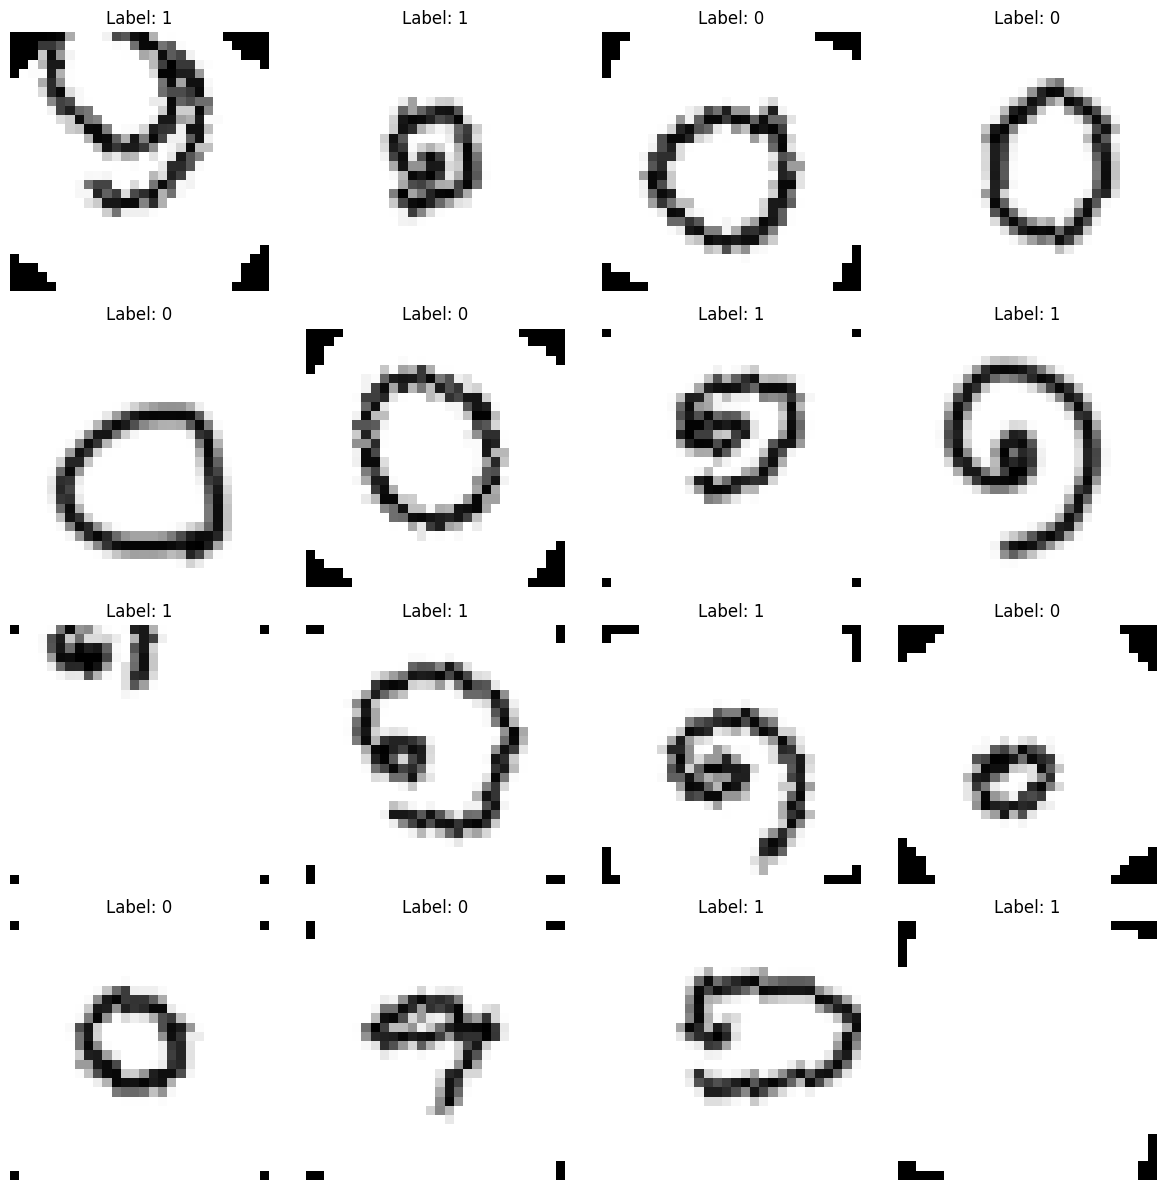

In [13]:
# Use the function to load data
class_names = ['0', '1']  # Specify the class names you want to load (e.g., class '0' and class '1')
train_loader, test_loader = load_data('./thai-handwriting-number.appspot.com/thai-handwriting-number.appspot.com', class_names)

# Display a batch of images from the train loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 16 images in the batch (4 x 4 grid)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 grid
axes = axes.flatten()  # Flatten the axes array to easily iterate

for i in range(16):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')  # Convert from (C, H, W) to (H, W)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')  # Hide axis labels

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [14]:
### START CODE HERE ###
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc = nn.Linear(28 * 28, 1)
        self.activation = nn.Sigmoid()

    def get_features(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        out = self.activation(out)
        return out

    def forward(self, x):
        return self.get_features(x)

# Multi-Layer Perceptron (Two FC layers)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        self.activation = nn.Sigmoid()

    def get_features(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        out = self.activation(self.fc2(x))
        return out

    def forward(self, x):
        return self.get_features(x)

# Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # Output: 16x28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: 32x28x28
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):
        x = self.relu(self.conv1(x))   # Shape: [B, 16, 28, 28]
        x = self.relu(self.conv2(x))   # Shape: [B, 32, 28, 28]
        x = x.view(x.size(0), -1)      # Flatten
        x = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x))
        return out

    def forward(self, x):
        return self.get_features(x)
### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [15]:
def show_featuremaps(feats):
    ### START CODE HERE ###
    feats = feats.detach().cpu().numpy().squeeze()  # Convert to numpy
    batch_size = feats.shape[0] if len(feats.shape) > 0 else 1

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(np.arange(batch_size), feats, color='skyblue')
    ax.set_title("Feature Outputs per Sample in Batch")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Feature Value")
    ax.set_ylim(0, 1)
    ### END CODE HERE ###
    return fig

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [21]:
def train(class_names,model,opt,loss_fn,train_loader,test_loader,epochs=10,writer=None,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###
    import matplotlib.pyplot as plt
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1), targets.float().clamp(0, 1))
            loss.backward()
            opt.step()

            train_loss += loss.item() * inputs.size(0)
            preds = (outputs.view(-1) > 0.5).int()
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Evaluation
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs.view(-1), targets.float().clamp(0, 1))
                test_loss += loss.item() * inputs.size(0)
                preds = (outputs.view(-1) > 0.5).int()
                correct += (preds == targets).sum().item()
                total += targets.size(0)

        avg_test_loss = test_loss / total
        test_acc = correct / total

        # Logging to TensorBoard
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Test', avg_test_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_acc, epoch)
            writer.add_scalar('Accuracy/Test', test_acc, epoch)

            # Feature maps
            try:
                if hasattr(model, "get_features"):
                    inputs, _ = next(iter(test_loader))
                    inputs = inputs.to(device)
                    features = model.get_features(inputs)
                    fig = show_featuremaps(features)
                    writer.add_figure("FeatureMaps", fig, global_step=epoch)
                    plt.close(fig)
            except Exception as e:
                print(f"⚠️ Couldn't log feature maps: {e}")

        print(f"✅ Epoch {epoch+1}/{epochs} | "
                f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)
        print(f"💾 Model saved to {checkpoint_path}")
    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [22]:
### START CODE HERE ###

import torch.optim as optim
from itertools import combinations

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.BCELoss()

# Map model names to their classes
model_classes = {
    'nn': NN,
    'mlp': MLP,
    'cnn': CNN,
}
digit_pairs = list(combinations(range(10), 2))

for (class_a, class_b) in digit_pairs:
    print(f"\n--- Training for pair: {class_a} vs {class_b} ---")
    
    # Load dataset filtered by the current pair of classes
    # Make sure load_data accepts a list of class names as strings, so:
    classes_for_pair = [str(class_a), str(class_b)]
    # train_loader, test_loader = load_data("thai-handwriting-number.appspot.com", classes_for_pair)
    
    # class_names = ['0', '1']
    train_loader, test_loader = load_data('./thai-handwriting-number.appspot.com/thai-handwriting-number.appspot.com', classes_for_pair)
    
    for name, ModelClass in model_classes.items():
        print(f"Training model: {name.upper()} on classes {class_a} vs {class_b}")
        
        writer = SummaryWriter(log_dir=f'runs/{class_a}_vs_{class_b}_{name}')
        model = ModelClass().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train(
            class_names=classes_for_pair,
            model=model,
            opt=optimizer,
            loss_fn=loss_fn,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=8,
            writer=writer,
            # checkpoint_path=f'checkpoints/{class_a}_vs_{class_b}_{name}.pth',
            checkpoint_path=f'./checkpoints/{class_a}_vs_{class_b}_{name}.pth',
            device=device
        )
        
        writer.close()

### END CODE HERE ###


--- Training for pair: 0 vs 1 ---
📃Train Dataset:
Number of images in class 0: 310
Number of images in class 1: 311
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.28it/s]

Number of images in class 0: 78
Number of images in class 1: 78
Number of testing samples: 156
Training model: NN on classes 0 vs 1


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.53it/s] 

✅ Epoch 1/8 | Train Loss: 0.6830, Train Acc: 0.5411 | Test Loss: 0.6805, Test Acc: 0.5064


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 24.41it/s] 

✅ Epoch 2/8 | Train Loss: 0.6667, Train Acc: 0.5717 | Test Loss: 0.6642, Test Acc: 0.5321


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 24.21it/s] 

✅ Epoch 3/8 | Train Loss: 0.6341, Train Acc: 0.6908 | Test Loss: 0.6314, Test Acc: 0.7115


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.25it/s] 

✅ Epoch 4/8 | Train Loss: 0.6254, Train Acc: 0.6908 | Test Loss: 0.6132, Test Acc: 0.6987


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.77it/s] 

✅ Epoch 5/8 | Train Loss: 0.6039, Train Acc: 0.7488 | Test Loss: 0.5877, Test Acc: 0.7949


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.42it/s] 

✅ Epoch 6/8 | Train Loss: 0.5950, Train Acc: 0.7343 | Test Loss: 0.5722, Test Acc: 0.7949


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 24.70it/s] 

✅ Epoch 7/8 | Train Loss: 0.5949, Train Acc: 0.7295 | Test Loss: 0.5658, Test Acc: 0.7692


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.41it/s] 

✅ Epoch 8/8 | Train Loss: 0.5848, Train Acc: 0.7359 | Test Loss: 0.5608, Test Acc: 0.7756
💾 Model saved to ./checkpoints/0_vs_1_nn.pth
Training model: MLP on classes 0 vs 1


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.60it/s] 

✅ Epoch 1/8 | Train Loss: 0.7070, Train Acc: 0.4895 | Test Loss: 0.6727, Test Acc: 0.7051


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 21.87it/s] 

✅ Epoch 2/8 | Train Loss: 0.6776, Train Acc: 0.5443 | Test Loss: 0.6593, Test Acc: 0.6282


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.53it/s] 

✅ Epoch 3/8 | Train Loss: 0.6583, Train Acc: 0.6184 | Test Loss: 0.6365, Test Acc: 0.6795


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.01it/s] 

✅ Epoch 4/8 | Train Loss: 0.6444, Train Acc: 0.6200 | Test Loss: 0.6510, Test Acc: 0.5128


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.34it/s] 

✅ Epoch 5/8 | Train Loss: 0.6494, Train Acc: 0.5910 | Test Loss: 0.6118, Test Acc: 0.6667


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.84it/s] 

✅ Epoch 6/8 | Train Loss: 0.6027, Train Acc: 0.7101 | Test Loss: 0.6037, Test Acc: 0.6538


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.83it/s] 

✅ Epoch 7/8 | Train Loss: 0.5891, Train Acc: 0.7085 | Test Loss: 0.5810, Test Acc: 0.7372


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.05it/s] 

✅ Epoch 8/8 | Train Loss: 0.5656, Train Acc: 0.7279 | Test Loss: 0.5603, Test Acc: 0.7628
💾 Model saved to ./checkpoints/0_vs_1_mlp.pth
Training model: CNN on classes 0 vs 1


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.72it/s] 

✅ Epoch 1/8 | Train Loss: 0.7216, Train Acc: 0.5298 | Test Loss: 0.6817, Test Acc: 0.6987


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.6637, Train Acc: 0.6731 | Test Loss: 0.6253, Test Acc: 0.6474


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.40it/s] 

✅ Epoch 3/8 | Train Loss: 0.5686, Train Acc: 0.7246 | Test Loss: 0.4996, Test Acc: 0.7692


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.96it/s] 

✅ Epoch 4/8 | Train Loss: 0.4588, Train Acc: 0.7874 | Test Loss: 0.4537, Test Acc: 0.7756


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.77it/s] 

✅ Epoch 5/8 | Train Loss: 0.4521, Train Acc: 0.7955 | Test Loss: 0.4813, Test Acc: 0.7885


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.85it/s] 

✅ Epoch 6/8 | Train Loss: 0.4274, Train Acc: 0.8068 | Test Loss: 0.4490, Test Acc: 0.7949


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.06it/s] 

✅ Epoch 7/8 | Train Loss: 0.3895, Train Acc: 0.8438 | Test Loss: 0.4543, Test Acc: 0.8205


✅ Epoch 8/8 | Train Loss: 0.3894, Train Acc: 0.8245 | Test Loss: 0.3973, Test Acc: 0.8269
💾 Model saved to ./checkpoints/0_vs_1_cnn.pth

--- Training for pair: 0 vs 2 ---
📃Train Dataset:
Number of images in class 0: 314
Number of images in class 2: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 24.50it/s]

Number of images in class 0: 74
Number of images in class 2: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 2


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.61it/s] 

✅ Epoch 1/8 | Train Loss: 0.7176, Train Acc: 0.3092 | Test Loss: 0.6946, Test Acc: 0.4295


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.57it/s] 

✅ Epoch 2/8 | Train Loss: 0.6655, Train Acc: 0.3510 | Test Loss: 0.6521, Test Acc: 0.2436


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.44it/s] 

✅ Epoch 3/8 | Train Loss: 0.6391, Train Acc: 0.3446 | Test Loss: 0.6464, Test Acc: 0.3397


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 24.36it/s] 

✅ Epoch 4/8 | Train Loss: 0.6144, Train Acc: 0.3994 | Test Loss: 0.6184, Test Acc: 0.2821


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 24.22it/s] 

✅ Epoch 5/8 | Train Loss: 0.6050, Train Acc: 0.3800 | Test Loss: 0.6219, Test Acc: 0.4615


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.72it/s] 

✅ Epoch 6/8 | Train Loss: 0.5803, Train Acc: 0.4122 | Test Loss: 0.5929, Test Acc: 0.4167


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.54it/s] 

✅ Epoch 7/8 | Train Loss: 0.5508, Train Acc: 0.4364 | Test Loss: 0.6114, Test Acc: 0.4038


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.38it/s] 

✅ Epoch 8/8 | Train Loss: 0.5423, Train Acc: 0.4589 | Test Loss: 0.6037, Test Acc: 0.2756
💾 Model saved to ./checkpoints/0_vs_2_nn.pth
Training model: MLP on classes 0 vs 2


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.59it/s] 

✅ Epoch 1/8 | Train Loss: 0.6845, Train Acc: 0.2850 | Test Loss: 0.6611, Test Acc: 0.0128


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.67it/s] 

✅ Epoch 2/8 | Train Loss: 0.6492, Train Acc: 0.3349 | Test Loss: 0.6368, Test Acc: 0.3910


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.92it/s] 

✅ Epoch 3/8 | Train Loss: 0.6067, Train Acc: 0.3704 | Test Loss: 0.6092, Test Acc: 0.2179


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.56it/s] 

✅ Epoch 4/8 | Train Loss: 0.5731, Train Acc: 0.4203 | Test Loss: 0.6117, Test Acc: 0.1218


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 20.94it/s] 

✅ Epoch 5/8 | Train Loss: 0.5404, Train Acc: 0.3994 | Test Loss: 0.5775, Test Acc: 0.3718


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.11it/s] 

✅ Epoch 6/8 | Train Loss: 0.5022, Train Acc: 0.4509 | Test Loss: 0.5239, Test Acc: 0.3654


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.39it/s] 

✅ Epoch 7/8 | Train Loss: 0.4732, Train Acc: 0.4332 | Test Loss: 0.5555, Test Acc: 0.3462


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

✅ Epoch 8/8 | Train Loss: 0.4746, Train Acc: 0.4332 | Test Loss: 0.5348, Test Acc: 0.2949
💾 Model saved to ./checkpoints/0_vs_2_mlp.pth
Training model: CNN on classes 0 vs 2


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.04it/s] 

✅ Epoch 1/8 | Train Loss: 0.6940, Train Acc: 0.3333 | Test Loss: 0.6171, Test Acc: 0.1795


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.05it/s] 

✅ Epoch 2/8 | Train Loss: 0.5023, Train Acc: 0.3961 | Test Loss: 0.5116, Test Acc: 0.4487


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.85it/s] 

✅ Epoch 3/8 | Train Loss: 0.4165, Train Acc: 0.4283 | Test Loss: 0.4252, Test Acc: 0.4038


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.86it/s] 

✅ Epoch 4/8 | Train Loss: 0.3329, Train Acc: 0.4541 | Test Loss: 0.4063, Test Acc: 0.4231


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 13.74it/s] 

✅ Epoch 5/8 | Train Loss: 0.3032, Train Acc: 0.4638 | Test Loss: 0.3944, Test Acc: 0.4615


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.40it/s] 

✅ Epoch 6/8 | Train Loss: 0.2863, Train Acc: 0.4767 | Test Loss: 0.3343, Test Acc: 0.4359


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.39it/s] 

✅ Epoch 7/8 | Train Loss: 0.2874, Train Acc: 0.4702 | Test Loss: 0.3440, Test Acc: 0.4487


✅ Epoch 8/8 | Train Loss: 0.2618, Train Acc: 0.4783 | Test Loss: 0.3769, Test Acc: 0.4615
💾 Model saved to ./checkpoints/0_vs_2_cnn.pth

--- Training for pair: 0 vs 3 ---
📃Train Dataset:
Number of images in class 0: 310
Number of images in class 3: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.83it/s]

Number of images in class 0: 78
Number of images in class 3: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 3


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.58it/s] 

✅ Epoch 1/8 | Train Loss: 0.6801, Train Acc: 0.2161 | Test Loss: 0.6505, Test Acc: 0.4679


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 25.29it/s] 

✅ Epoch 2/8 | Train Loss: 0.6508, Train Acc: 0.3097 | Test Loss: 0.6237, Test Acc: 0.3333


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 24.47it/s] 

✅ Epoch 3/8 | Train Loss: 0.6228, Train Acc: 0.3694 | Test Loss: 0.6168, Test Acc: 0.3910


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.63it/s] 

✅ Epoch 4/8 | Train Loss: 0.6012, Train Acc: 0.4161 | Test Loss: 0.5844, Test Acc: 0.3462


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.40it/s] 

✅ Epoch 5/8 | Train Loss: 0.5788, Train Acc: 0.4016 | Test Loss: 0.5998, Test Acc: 0.2436


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.80it/s] 

✅ Epoch 6/8 | Train Loss: 0.5708, Train Acc: 0.3968 | Test Loss: 0.5708, Test Acc: 0.3590


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 20.72it/s] 

✅ Epoch 7/8 | Train Loss: 0.5660, Train Acc: 0.3661 | Test Loss: 0.6103, Test Acc: 0.1218


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.43it/s] 

✅ Epoch 8/8 | Train Loss: 0.5672, Train Acc: 0.3516 | Test Loss: 0.5525, Test Acc: 0.3590
💾 Model saved to ./checkpoints/0_vs_3_nn.pth
Training model: MLP on classes 0 vs 3


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.37it/s] 

✅ Epoch 1/8 | Train Loss: 0.6876, Train Acc: 0.3419 | Test Loss: 0.6648, Test Acc: 0.0128


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 11.38it/s] 

✅ Epoch 2/8 | Train Loss: 0.6717, Train Acc: 0.3177 | Test Loss: 0.6331, Test Acc: 0.4808


Epoch 4/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 3/8 | Train Loss: 0.6196, Train Acc: 0.3435 | Test Loss: 0.6027, Test Acc: 0.4359


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 10.80it/s] 

✅ Epoch 4/8 | Train Loss: 0.6078, Train Acc: 0.3548 | Test Loss: 0.6086, Test Acc: 0.1154


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.44it/s] 

✅ Epoch 5/8 | Train Loss: 0.5726, Train Acc: 0.3710 | Test Loss: 0.5444, Test Acc: 0.3910


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.59it/s] 

✅ Epoch 6/8 | Train Loss: 0.5451, Train Acc: 0.3952 | Test Loss: 0.5273, Test Acc: 0.3269


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.28it/s] 

✅ Epoch 7/8 | Train Loss: 0.5149, Train Acc: 0.4000 | Test Loss: 0.5163, Test Acc: 0.4167


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

✅ Epoch 8/8 | Train Loss: 0.5074, Train Acc: 0.4161 | Test Loss: 0.5238, Test Acc: 0.3077
💾 Model saved to ./checkpoints/0_vs_3_mlp.pth
Training model: CNN on classes 0 vs 3


Epoch 2/8:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

✅ Epoch 1/8 | Train Loss: 0.7596, Train Acc: 0.2258 | Test Loss: 0.6862, Test Acc: 0.0000


Epoch 3/8:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

✅ Epoch 2/8 | Train Loss: 0.6566, Train Acc: 0.2968 | Test Loss: 0.6004, Test Acc: 0.2821


Epoch 4/8:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

✅ Epoch 3/8 | Train Loss: 0.5178, Train Acc: 0.3968 | Test Loss: 0.4879, Test Acc: 0.4038


Epoch 5/8:   5%|▌         | 1/20 [00:00<00:02,  7.88it/s] 

✅ Epoch 4/8 | Train Loss: 0.4391, Train Acc: 0.4016 | Test Loss: 0.4640, Test Acc: 0.4295


Epoch 6/8:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s] 

✅ Epoch 5/8 | Train Loss: 0.4175, Train Acc: 0.4242 | Test Loss: 0.4784, Test Acc: 0.3269


Epoch 7/8:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s] 

✅ Epoch 6/8 | Train Loss: 0.4218, Train Acc: 0.4000 | Test Loss: 0.4062, Test Acc: 0.4359


Epoch 8/8:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s] 

✅ Epoch 7/8 | Train Loss: 0.3759, Train Acc: 0.4403 | Test Loss: 0.4384, Test Acc: 0.4167


✅ Epoch 8/8 | Train Loss: 0.3451, Train Acc: 0.4484 | Test Loss: 0.4107, Test Acc: 0.3782
💾 Model saved to ./checkpoints/0_vs_3_cnn.pth

--- Training for pair: 0 vs 4 ---
📃Train Dataset:
Number of images in class 0: 323
Number of images in class 4: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 11.79it/s]

Number of images in class 0: 65
Number of images in class 4: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.73it/s] 

✅ Epoch 1/8 | Train Loss: 0.7098, Train Acc: 0.3500 | Test Loss: 0.6718, Test Acc: 0.1282


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 11.96it/s] 

✅ Epoch 2/8 | Train Loss: 0.6629, Train Acc: 0.3677 | Test Loss: 0.6727, Test Acc: 0.4167


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.50it/s] 

✅ Epoch 3/8 | Train Loss: 0.6336, Train Acc: 0.3806 | Test Loss: 0.6282, Test Acc: 0.3462


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.77it/s] 

✅ Epoch 4/8 | Train Loss: 0.6175, Train Acc: 0.4323 | Test Loss: 0.6260, Test Acc: 0.4103


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.66it/s] 

✅ Epoch 5/8 | Train Loss: 0.5972, Train Acc: 0.4161 | Test Loss: 0.6578, Test Acc: 0.4103


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.57it/s] 

✅ Epoch 6/8 | Train Loss: 0.5718, Train Acc: 0.4081 | Test Loss: 0.5672, Test Acc: 0.3205


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.81it/s] 

✅ Epoch 7/8 | Train Loss: 0.5585, Train Acc: 0.4081 | Test Loss: 0.6427, Test Acc: 0.4167


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 11.31it/s] 

✅ Epoch 8/8 | Train Loss: 0.5504, Train Acc: 0.4081 | Test Loss: 0.5430, Test Acc: 0.3205
💾 Model saved to ./checkpoints/0_vs_4_nn.pth
Training model: MLP on classes 0 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.46it/s] 

✅ Epoch 1/8 | Train Loss: 0.7013, Train Acc: 0.3677 | Test Loss: 0.6567, Test Acc: 0.0000


Epoch 3/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 2/8 | Train Loss: 0.6681, Train Acc: 0.3403 | Test Loss: 0.6638, Test Acc: 0.4167


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.44it/s] 

✅ Epoch 3/8 | Train Loss: 0.6423, Train Acc: 0.3516 | Test Loss: 0.6039, Test Acc: 0.2885


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.35it/s] 

✅ Epoch 4/8 | Train Loss: 0.6196, Train Acc: 0.3500 | Test Loss: 0.5723, Test Acc: 0.2372


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.44it/s] 

✅ Epoch 5/8 | Train Loss: 0.5872, Train Acc: 0.4097 | Test Loss: 0.6379, Test Acc: 0.4167


Epoch 7/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 6/8 | Train Loss: 0.5604, Train Acc: 0.4065 | Test Loss: 0.5386, Test Acc: 0.2821


Epoch 8/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 7/8 | Train Loss: 0.5452, Train Acc: 0.4016 | Test Loss: 0.5350, Test Acc: 0.3654


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

✅ Epoch 8/8 | Train Loss: 0.5393, Train Acc: 0.4177 | Test Loss: 0.5126, Test Acc: 0.1987
💾 Model saved to ./checkpoints/0_vs_4_mlp.pth
Training model: CNN on classes 0 vs 4


Epoch 2/8:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

✅ Epoch 1/8 | Train Loss: 0.7735, Train Acc: 0.4032 | Test Loss: 0.6823, Test Acc: 0.3333


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.92it/s] 

✅ Epoch 2/8 | Train Loss: 0.6627, Train Acc: 0.3016 | Test Loss: 0.6162, Test Acc: 0.3718


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 14.07it/s] 

✅ Epoch 3/8 | Train Loss: 0.5455, Train Acc: 0.4323 | Test Loss: 0.4597, Test Acc: 0.3141


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.41it/s] 

✅ Epoch 4/8 | Train Loss: 0.4430, Train Acc: 0.4306 | Test Loss: 0.4646, Test Acc: 0.3782


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.05it/s] 

✅ Epoch 5/8 | Train Loss: 0.3646, Train Acc: 0.4484 | Test Loss: 0.3717, Test Acc: 0.3782


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.26it/s] 

✅ Epoch 6/8 | Train Loss: 0.3210, Train Acc: 0.4774 | Test Loss: 0.3225, Test Acc: 0.3333


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.16it/s] 

✅ Epoch 7/8 | Train Loss: 0.2709, Train Acc: 0.4790 | Test Loss: 0.3058, Test Acc: 0.3974


✅ Epoch 8/8 | Train Loss: 0.2513, Train Acc: 0.4952 | Test Loss: 0.2653, Test Acc: 0.3782
💾 Model saved to ./checkpoints/0_vs_4_cnn.pth

--- Training for pair: 0 vs 5 ---
📃Train Dataset:
Number of images in class 0: 311
Number of images in class 5: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.61it/s]

Number of images in class 0: 77
Number of images in class 5: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.19it/s] 

✅ Epoch 1/8 | Train Loss: 0.7185, Train Acc: 0.2952 | Test Loss: 0.6701, Test Acc: 0.4423


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.78it/s] 

✅ Epoch 2/8 | Train Loss: 0.6666, Train Acc: 0.3919 | Test Loss: 0.6341, Test Acc: 0.3077


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.36it/s] 

✅ Epoch 3/8 | Train Loss: 0.6329, Train Acc: 0.4016 | Test Loss: 0.6098, Test Acc: 0.4872


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 20.73it/s] 

✅ Epoch 4/8 | Train Loss: 0.6117, Train Acc: 0.4403 | Test Loss: 0.5946, Test Acc: 0.2500


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.92it/s] 

✅ Epoch 5/8 | Train Loss: 0.5962, Train Acc: 0.3452 | Test Loss: 0.5685, Test Acc: 0.4359


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.50it/s] 

✅ Epoch 6/8 | Train Loss: 0.5660, Train Acc: 0.4339 | Test Loss: 0.5541, Test Acc: 0.4423


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.75it/s] 

✅ Epoch 7/8 | Train Loss: 0.5474, Train Acc: 0.4532 | Test Loss: 0.5279, Test Acc: 0.3526


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.24it/s] 

✅ Epoch 8/8 | Train Loss: 0.5507, Train Acc: 0.3871 | Test Loss: 0.5342, Test Acc: 0.3269
💾 Model saved to ./checkpoints/0_vs_5_nn.pth
Training model: MLP on classes 0 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.34it/s] 

✅ Epoch 1/8 | Train Loss: 0.7132, Train Acc: 0.2403 | Test Loss: 0.6668, Test Acc: 0.4936


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 14.38it/s] 

✅ Epoch 2/8 | Train Loss: 0.6624, Train Acc: 0.3081 | Test Loss: 0.6519, Test Acc: 0.4936


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.27it/s] 

✅ Epoch 3/8 | Train Loss: 0.6267, Train Acc: 0.3887 | Test Loss: 0.5886, Test Acc: 0.4103


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 21.53it/s] 

✅ Epoch 4/8 | Train Loss: 0.5927, Train Acc: 0.3468 | Test Loss: 0.5528, Test Acc: 0.4231


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.70it/s] 

✅ Epoch 5/8 | Train Loss: 0.5405, Train Acc: 0.4387 | Test Loss: 0.5080, Test Acc: 0.4679


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.21it/s] 

✅ Epoch 6/8 | Train Loss: 0.5179, Train Acc: 0.4161 | Test Loss: 0.4658, Test Acc: 0.4744


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.73it/s] 

✅ Epoch 7/8 | Train Loss: 0.4908, Train Acc: 0.4371 | Test Loss: 0.4762, Test Acc: 0.3718


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.29it/s] 

✅ Epoch 8/8 | Train Loss: 0.4975, Train Acc: 0.3984 | Test Loss: 0.5264, Test Acc: 0.4936
💾 Model saved to ./checkpoints/0_vs_5_mlp.pth
Training model: CNN on classes 0 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.77it/s] 

✅ Epoch 1/8 | Train Loss: 0.7012, Train Acc: 0.3290 | Test Loss: 0.6253, Test Acc: 0.3654


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.52it/s] 

✅ Epoch 2/8 | Train Loss: 0.5279, Train Acc: 0.4161 | Test Loss: 0.4564, Test Acc: 0.3269


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.65it/s] 

✅ Epoch 3/8 | Train Loss: 0.3518, Train Acc: 0.4645 | Test Loss: 0.3154, Test Acc: 0.4423


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.61it/s] 

✅ Epoch 4/8 | Train Loss: 0.3008, Train Acc: 0.4629 | Test Loss: 0.2723, Test Acc: 0.4615


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.10it/s] 

✅ Epoch 5/8 | Train Loss: 0.2668, Train Acc: 0.4758 | Test Loss: 0.2614, Test Acc: 0.4679


Epoch 7/8:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

✅ Epoch 6/8 | Train Loss: 0.2145, Train Acc: 0.4839 | Test Loss: 0.2118, Test Acc: 0.4744


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 14.90it/s] 

✅ Epoch 7/8 | Train Loss: 0.2113, Train Acc: 0.4790 | Test Loss: 0.2178, Test Acc: 0.4744


✅ Epoch 8/8 | Train Loss: 0.1815, Train Acc: 0.4903 | Test Loss: 0.2042, Test Acc: 0.4744
💾 Model saved to ./checkpoints/0_vs_5_cnn.pth

--- Training for pair: 0 vs 6 ---
📃Train Dataset:
Number of images in class 0: 310
Number of images in class 6: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.89it/s]

Number of images in class 0: 78
Number of images in class 6: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.55it/s] 

✅ Epoch 1/8 | Train Loss: 0.7197, Train Acc: 0.2371 | Test Loss: 0.6872, Test Acc: 0.3718


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 24.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.6898, Train Acc: 0.3339 | Test Loss: 0.6916, Test Acc: 0.4744


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 24.16it/s] 

✅ Epoch 3/8 | Train Loss: 0.6795, Train Acc: 0.2806 | Test Loss: 0.6733, Test Acc: 0.3718


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.28it/s] 

✅ Epoch 4/8 | Train Loss: 0.6791, Train Acc: 0.3177 | Test Loss: 0.6731, Test Acc: 0.4936


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.43it/s] 

✅ Epoch 5/8 | Train Loss: 0.6711, Train Acc: 0.3081 | Test Loss: 0.6894, Test Acc: 0.5000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.25it/s] 

✅ Epoch 6/8 | Train Loss: 0.6576, Train Acc: 0.3113 | Test Loss: 0.6442, Test Acc: 0.3910


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 24.14it/s] 

✅ Epoch 7/8 | Train Loss: 0.6516, Train Acc: 0.3435 | Test Loss: 0.6425, Test Acc: 0.2564


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.49it/s] 

✅ Epoch 8/8 | Train Loss: 0.6416, Train Acc: 0.3065 | Test Loss: 0.6610, Test Acc: 0.4936
💾 Model saved to ./checkpoints/0_vs_6_nn.pth
Training model: MLP on classes 0 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.27it/s] 

✅ Epoch 1/8 | Train Loss: 0.7303, Train Acc: 0.2016 | Test Loss: 0.6883, Test Acc: 0.3526


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.63it/s] 

✅ Epoch 2/8 | Train Loss: 0.6963, Train Acc: 0.2919 | Test Loss: 0.6850, Test Acc: 0.5000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.22it/s] 

✅ Epoch 3/8 | Train Loss: 0.6893, Train Acc: 0.3484 | Test Loss: 0.6829, Test Acc: 0.0769


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.77it/s] 

✅ Epoch 4/8 | Train Loss: 0.6795, Train Acc: 0.2548 | Test Loss: 0.6756, Test Acc: 0.5000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.29it/s] 

✅ Epoch 5/8 | Train Loss: 0.6765, Train Acc: 0.3032 | Test Loss: 0.6658, Test Acc: 0.4103


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.25it/s] 

✅ Epoch 6/8 | Train Loss: 0.6835, Train Acc: 0.3129 | Test Loss: 0.6691, Test Acc: 0.0064


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.47it/s] 

✅ Epoch 7/8 | Train Loss: 0.6720, Train Acc: 0.2952 | Test Loss: 0.6613, Test Acc: 0.1859


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.86it/s] 

✅ Epoch 8/8 | Train Loss: 0.6667, Train Acc: 0.3242 | Test Loss: 0.6574, Test Acc: 0.4744
💾 Model saved to ./checkpoints/0_vs_6_mlp.pth
Training model: CNN on classes 0 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.92it/s] 

✅ Epoch 1/8 | Train Loss: 0.7004, Train Acc: 0.2935 | Test Loss: 0.6597, Test Acc: 0.0385


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.47it/s] 

✅ Epoch 2/8 | Train Loss: 0.6269, Train Acc: 0.3677 | Test Loss: 0.5760, Test Acc: 0.3590


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.80it/s] 

✅ Epoch 3/8 | Train Loss: 0.5103, Train Acc: 0.4210 | Test Loss: 0.5115, Test Acc: 0.4359


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.12it/s] 

✅ Epoch 4/8 | Train Loss: 0.4283, Train Acc: 0.4306 | Test Loss: 0.5506, Test Acc: 0.3141


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.38it/s] 

✅ Epoch 5/8 | Train Loss: 0.3730, Train Acc: 0.4306 | Test Loss: 0.4113, Test Acc: 0.4103


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.23it/s] 

✅ Epoch 6/8 | Train Loss: 0.3267, Train Acc: 0.4661 | Test Loss: 0.4415, Test Acc: 0.3910


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.29it/s] 

✅ Epoch 7/8 | Train Loss: 0.3103, Train Acc: 0.4597 | Test Loss: 0.3373, Test Acc: 0.4423


✅ Epoch 8/8 | Train Loss: 0.2830, Train Acc: 0.4548 | Test Loss: 0.4565, Test Acc: 0.4615
💾 Model saved to ./checkpoints/0_vs_6_cnn.pth

--- Training for pair: 0 vs 7 ---
📃Train Dataset:
Number of images in class 0: 312
Number of images in class 7: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.80it/s]

Number of images in class 0: 76
Number of images in class 7: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 24.02it/s] 

✅ Epoch 1/8 | Train Loss: 0.6939, Train Acc: 0.2387 | Test Loss: 0.6758, Test Acc: 0.4808


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.56it/s] 

✅ Epoch 2/8 | Train Loss: 0.6762, Train Acc: 0.3500 | Test Loss: 0.6424, Test Acc: 0.4423


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.73it/s] 

✅ Epoch 3/8 | Train Loss: 0.6446, Train Acc: 0.3839 | Test Loss: 0.6249, Test Acc: 0.3910


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.46it/s] 

✅ Epoch 4/8 | Train Loss: 0.6230, Train Acc: 0.4177 | Test Loss: 0.6017, Test Acc: 0.3333


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.97it/s] 

✅ Epoch 5/8 | Train Loss: 0.6135, Train Acc: 0.3629 | Test Loss: 0.5892, Test Acc: 0.2949


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.57it/s] 

✅ Epoch 6/8 | Train Loss: 0.6109, Train Acc: 0.3661 | Test Loss: 0.6270, Test Acc: 0.4808


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.43it/s] 

✅ Epoch 7/8 | Train Loss: 0.6052, Train Acc: 0.3774 | Test Loss: 0.5675, Test Acc: 0.4615


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.73it/s] 

✅ Epoch 8/8 | Train Loss: 0.5674, Train Acc: 0.4323 | Test Loss: 0.5687, Test Acc: 0.3333
💾 Model saved to ./checkpoints/0_vs_7_nn.pth
Training model: MLP on classes 0 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.39it/s] 

✅ Epoch 1/8 | Train Loss: 0.7100, Train Acc: 0.2548 | Test Loss: 0.6901, Test Acc: 0.4872


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 20.83it/s] 

✅ Epoch 2/8 | Train Loss: 0.6886, Train Acc: 0.3661 | Test Loss: 0.6861, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.69it/s] 

✅ Epoch 3/8 | Train Loss: 0.6611, Train Acc: 0.3113 | Test Loss: 0.6565, Test Acc: 0.4872


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.27it/s] 

✅ Epoch 4/8 | Train Loss: 0.6337, Train Acc: 0.3903 | Test Loss: 0.6019, Test Acc: 0.4231


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.66it/s] 

✅ Epoch 5/8 | Train Loss: 0.6075, Train Acc: 0.3645 | Test Loss: 0.5963, Test Acc: 0.4808


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.75it/s] 

✅ Epoch 6/8 | Train Loss: 0.5940, Train Acc: 0.3984 | Test Loss: 0.5679, Test Acc: 0.3141


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 21.98it/s] 

✅ Epoch 7/8 | Train Loss: 0.5606, Train Acc: 0.3952 | Test Loss: 0.5795, Test Acc: 0.2115


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.71it/s] 

✅ Epoch 8/8 | Train Loss: 0.5491, Train Acc: 0.3984 | Test Loss: 0.5264, Test Acc: 0.3526
💾 Model saved to ./checkpoints/0_vs_7_mlp.pth
Training model: CNN on classes 0 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.24it/s] 

✅ Epoch 1/8 | Train Loss: 0.7722, Train Acc: 0.2661 | Test Loss: 0.6815, Test Acc: 0.4872


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.87it/s] 

✅ Epoch 2/8 | Train Loss: 0.6547, Train Acc: 0.3710 | Test Loss: 0.5748, Test Acc: 0.4679


Epoch 4/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 3/8 | Train Loss: 0.5539, Train Acc: 0.3984 | Test Loss: 0.4788, Test Acc: 0.4744


Epoch 5/8:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s] 

✅ Epoch 4/8 | Train Loss: 0.4219, Train Acc: 0.4403 | Test Loss: 0.4012, Test Acc: 0.4551


Epoch 6/8:   5%|▌         | 1/20 [00:00<00:02,  8.89it/s] 

✅ Epoch 5/8 | Train Loss: 0.3800, Train Acc: 0.4565 | Test Loss: 0.3515, Test Acc: 0.4487


Epoch 7/8:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

✅ Epoch 6/8 | Train Loss: 0.3435, Train Acc: 0.4581 | Test Loss: 0.3527, Test Acc: 0.4359


Epoch 8/8:   5%|▌         | 1/20 [00:00<00:02,  8.99it/s] 

✅ Epoch 7/8 | Train Loss: 0.3368, Train Acc: 0.4532 | Test Loss: 0.3689, Test Acc: 0.4551


✅ Epoch 8/8 | Train Loss: 0.2967, Train Acc: 0.4726 | Test Loss: 0.3005, Test Acc: 0.4551
💾 Model saved to ./checkpoints/0_vs_7_cnn.pth

--- Training for pair: 0 vs 8 ---
📃Train Dataset:
Number of images in class 0: 320
Number of images in class 8: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 12.28it/s]

Number of images in class 0: 68
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.80it/s] 

✅ Epoch 1/8 | Train Loss: 0.7280, Train Acc: 0.3258 | Test Loss: 0.7355, Test Acc: 0.4359


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 11.71it/s] 

✅ Epoch 2/8 | Train Loss: 0.6957, Train Acc: 0.3871 | Test Loss: 0.6824, Test Acc: 0.2115


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.84it/s] 

✅ Epoch 3/8 | Train Loss: 0.6828, Train Acc: 0.3532 | Test Loss: 0.6680, Test Acc: 0.0962


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.87it/s] 

✅ Epoch 4/8 | Train Loss: 0.6774, Train Acc: 0.3306 | Test Loss: 0.7491, Test Acc: 0.4359


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.73it/s] 

✅ Epoch 5/8 | Train Loss: 0.6747, Train Acc: 0.3774 | Test Loss: 0.7313, Test Acc: 0.4359


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 12.36it/s] 

✅ Epoch 6/8 | Train Loss: 0.6571, Train Acc: 0.3516 | Test Loss: 0.6721, Test Acc: 0.2885


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.03it/s] 

✅ Epoch 7/8 | Train Loss: 0.6449, Train Acc: 0.3823 | Test Loss: 0.6633, Test Acc: 0.3141


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 11.69it/s] 

✅ Epoch 8/8 | Train Loss: 0.6497, Train Acc: 0.4403 | Test Loss: 0.6492, Test Acc: 0.1154
💾 Model saved to ./checkpoints/0_vs_8_nn.pth
Training model: MLP on classes 0 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.49it/s] 

✅ Epoch 1/8 | Train Loss: 0.7473, Train Acc: 0.2194 | Test Loss: 0.6807, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 11.55it/s] 

✅ Epoch 2/8 | Train Loss: 0.7008, Train Acc: 0.4597 | Test Loss: 0.6919, Test Acc: 0.4295


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.89it/s] 

✅ Epoch 3/8 | Train Loss: 0.6888, Train Acc: 0.2177 | Test Loss: 0.6923, Test Acc: 0.4359


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.70it/s] 

✅ Epoch 4/8 | Train Loss: 0.6873, Train Acc: 0.3419 | Test Loss: 0.7007, Test Acc: 0.4359


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

✅ Epoch 5/8 | Train Loss: 0.6809, Train Acc: 0.2903 | Test Loss: 0.6919, Test Acc: 0.4359


Epoch 7/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 6/8 | Train Loss: 0.6738, Train Acc: 0.4129 | Test Loss: 0.6664, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.50it/s] 

✅ Epoch 7/8 | Train Loss: 0.6741, Train Acc: 0.3548 | Test Loss: 0.6556, Test Acc: 0.0513


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

✅ Epoch 8/8 | Train Loss: 0.6764, Train Acc: 0.3468 | Test Loss: 0.6839, Test Acc: 0.4359
💾 Model saved to ./checkpoints/0_vs_8_mlp.pth
Training model: CNN on classes 0 vs 8


Epoch 2/8:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

✅ Epoch 1/8 | Train Loss: 0.7944, Train Acc: 0.3081 | Test Loss: 0.7245, Test Acc: 0.4359


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.38it/s] 

✅ Epoch 2/8 | Train Loss: 0.6881, Train Acc: 0.4323 | Test Loss: 0.6815, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 3/8 | Train Loss: 0.6728, Train Acc: 0.1839 | Test Loss: 0.6626, Test Acc: 0.3654


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.92it/s] 

✅ Epoch 4/8 | Train Loss: 0.5939, Train Acc: 0.4113 | Test Loss: 0.6197, Test Acc: 0.1090


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.15it/s] 

✅ Epoch 5/8 | Train Loss: 0.5491, Train Acc: 0.3903 | Test Loss: 0.5532, Test Acc: 0.3013


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.50it/s] 

✅ Epoch 6/8 | Train Loss: 0.4347, Train Acc: 0.4581 | Test Loss: 0.5470, Test Acc: 0.3718


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.15it/s] 

✅ Epoch 7/8 | Train Loss: 0.3666, Train Acc: 0.4742 | Test Loss: 0.4669, Test Acc: 0.3718


✅ Epoch 8/8 | Train Loss: 0.3558, Train Acc: 0.4774 | Test Loss: 0.4118, Test Acc: 0.3910
💾 Model saved to ./checkpoints/0_vs_8_cnn.pth

--- Training for pair: 0 vs 9 ---
📃Train Dataset:
Number of images in class 0: 319
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]

Number of images in class 0: 69
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 0 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.18it/s] 

✅ Epoch 1/8 | Train Loss: 0.7123, Train Acc: 0.3048 | Test Loss: 0.6905, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.03it/s] 

✅ Epoch 2/8 | Train Loss: 0.6972, Train Acc: 0.2516 | Test Loss: 0.6618, Test Acc: 0.3269


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.65it/s] 

✅ Epoch 3/8 | Train Loss: 0.6573, Train Acc: 0.3387 | Test Loss: 0.6917, Test Acc: 0.4359


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 10.80it/s] 

✅ Epoch 4/8 | Train Loss: 0.6306, Train Acc: 0.4323 | Test Loss: 0.6275, Test Acc: 0.1603


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.59it/s] 

✅ Epoch 5/8 | Train Loss: 0.6123, Train Acc: 0.3855 | Test Loss: 0.6232, Test Acc: 0.3333


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.46it/s] 

✅ Epoch 6/8 | Train Loss: 0.5938, Train Acc: 0.4016 | Test Loss: 0.6299, Test Acc: 0.3846


Epoch 8/8:   5%|▌         | 1/20 [00:00<00:02,  8.89it/s] 

✅ Epoch 7/8 | Train Loss: 0.5742, Train Acc: 0.3984 | Test Loss: 0.6502, Test Acc: 0.4231


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.5813, Train Acc: 0.4097 | Test Loss: 0.6217, Test Acc: 0.4038
💾 Model saved to ./checkpoints/0_vs_9_nn.pth
Training model: MLP on classes 0 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.42it/s] 

✅ Epoch 1/8 | Train Loss: 0.6952, Train Acc: 0.3790 | Test Loss: 0.6654, Test Acc: 0.0641


Epoch 3/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 2/8 | Train Loss: 0.6754, Train Acc: 0.3016 | Test Loss: 0.7351, Test Acc: 0.4423


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

✅ Epoch 3/8 | Train Loss: 0.6356, Train Acc: 0.3597 | Test Loss: 0.6605, Test Acc: 0.4103


Epoch 5/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 4/8 | Train Loss: 0.5998, Train Acc: 0.4048 | Test Loss: 0.5896, Test Acc: 0.2949


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.86it/s] 

✅ Epoch 5/8 | Train Loss: 0.5672, Train Acc: 0.4145 | Test Loss: 0.5836, Test Acc: 0.2628


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.60it/s] 

✅ Epoch 6/8 | Train Loss: 0.5369, Train Acc: 0.4000 | Test Loss: 0.6491, Test Acc: 0.4231


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.67it/s] 

✅ Epoch 7/8 | Train Loss: 0.5157, Train Acc: 0.4258 | Test Loss: 0.5666, Test Acc: 0.2436


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

✅ Epoch 8/8 | Train Loss: 0.5129, Train Acc: 0.4145 | Test Loss: 0.5368, Test Acc: 0.3205
💾 Model saved to ./checkpoints/0_vs_9_mlp.pth
Training model: CNN on classes 0 vs 9


Epoch 2/8:   5%|▌         | 1/20 [00:00<00:02,  8.16it/s] 

✅ Epoch 1/8 | Train Loss: 0.7346, Train Acc: 0.3645 | Test Loss: 0.6506, Test Acc: 0.0128


Epoch 3/8:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

✅ Epoch 2/8 | Train Loss: 0.5773, Train Acc: 0.3565 | Test Loss: 0.5837, Test Acc: 0.4103


Epoch 4/8:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s] 

✅ Epoch 3/8 | Train Loss: 0.4273, Train Acc: 0.4194 | Test Loss: 0.5685, Test Acc: 0.3526


Epoch 5/8:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

✅ Epoch 4/8 | Train Loss: 0.3568, Train Acc: 0.4581 | Test Loss: 0.4540, Test Acc: 0.3526


Epoch 6/8:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s] 

✅ Epoch 5/8 | Train Loss: 0.3179, Train Acc: 0.4597 | Test Loss: 0.4599, Test Acc: 0.3846


Epoch 7/8:   5%|▌         | 1/20 [00:00<00:02,  8.94it/s] 

✅ Epoch 6/8 | Train Loss: 0.2679, Train Acc: 0.4758 | Test Loss: 0.4438, Test Acc: 0.3590


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.00it/s] 

✅ Epoch 7/8 | Train Loss: 0.2531, Train Acc: 0.4742 | Test Loss: 0.4038, Test Acc: 0.3782


✅ Epoch 8/8 | Train Loss: 0.2333, Train Acc: 0.4742 | Test Loss: 0.3812, Test Acc: 0.3718
💾 Model saved to ./checkpoints/0_vs_9_cnn.pth

--- Training for pair: 1 vs 2 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 2: 314
Number of training samples: 622

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.75it/s]

Number of images in class 1: 0
Number of images in class 2: 75
Number of testing samples: 156
Training model: NN on classes 1 vs 2


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.91it/s] 

✅ Epoch 1/8 | Train Loss: 0.0714, Train Acc: 0.5032 | Test Loss: 0.0009, Test Acc: 0.4808


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.70it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.5048 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 24.07it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.5048 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.62it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.5048 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 20.28it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.5048 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.38it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.5048 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.70it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.5048 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.89it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.5048 | Test Loss: 0.0002, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_2_nn.pth
Training model: MLP on classes 1 vs 2


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.31it/s] 

✅ Epoch 1/8 | Train Loss: 0.1614, Train Acc: 0.4775 | Test Loss: 0.0484, Test Acc: 0.4808


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.11it/s] 

✅ Epoch 2/8 | Train Loss: 0.0383, Train Acc: 0.5048 | Test Loss: 0.0294, Test Acc: 0.4808


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.22it/s] 

✅ Epoch 3/8 | Train Loss: 0.0247, Train Acc: 0.5048 | Test Loss: 0.0203, Test Acc: 0.4808


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.02it/s] 

✅ Epoch 4/8 | Train Loss: 0.0177, Train Acc: 0.5048 | Test Loss: 0.0151, Test Acc: 0.4808


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.52it/s] 

✅ Epoch 5/8 | Train Loss: 0.0135, Train Acc: 0.5048 | Test Loss: 0.0118, Test Acc: 0.4808


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.64it/s] 

✅ Epoch 6/8 | Train Loss: 0.0107, Train Acc: 0.5048 | Test Loss: 0.0095, Test Acc: 0.4808


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 21.20it/s] 

✅ Epoch 7/8 | Train Loss: 0.0087, Train Acc: 0.5048 | Test Loss: 0.0078, Test Acc: 0.4808


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 16.03it/s] 

✅ Epoch 8/8 | Train Loss: 0.0072, Train Acc: 0.5048 | Test Loss: 0.0066, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_2_mlp.pth
Training model: CNN on classes 1 vs 2


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.15it/s] 

✅ Epoch 1/8 | Train Loss: 0.0384, Train Acc: 0.4855 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.06it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.18it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.66it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.70it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 14.84it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.77it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5048 | Test Loss: 0.0000, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_2_cnn.pth

--- Training for pair: 1 vs 3 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 3: 314
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 11.78it/s]

Number of images in class 1: 0
Number of images in class 3: 75
Number of testing samples: 156
Training model: NN on classes 1 vs 3


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 12.21it/s] 

✅ Epoch 1/8 | Train Loss: 0.1015, Train Acc: 0.4863 | Test Loss: 0.0012, Test Acc: 0.4808


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 11.68it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.5056 | Test Loss: 0.0004, Test Acc: 0.4808


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.85it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.76it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 12.07it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.90it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 12.00it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 10.48it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0002, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_3_nn.pth
Training model: MLP on classes 1 vs 3


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.65it/s] 

✅ Epoch 1/8 | Train Loss: 0.1088, Train Acc: 0.4734 | Test Loss: 0.0257, Test Acc: 0.4808


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 11.21it/s] 

✅ Epoch 2/8 | Train Loss: 0.0201, Train Acc: 0.5056 | Test Loss: 0.0154, Test Acc: 0.4808


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

✅ Epoch 3/8 | Train Loss: 0.0130, Train Acc: 0.5056 | Test Loss: 0.0107, Test Acc: 0.4808


Epoch 5/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 4/8 | Train Loss: 0.0093, Train Acc: 0.5056 | Test Loss: 0.0080, Test Acc: 0.4808


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.34it/s] 

✅ Epoch 5/8 | Train Loss: 0.0071, Train Acc: 0.5056 | Test Loss: 0.0062, Test Acc: 0.4808


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

✅ Epoch 6/8 | Train Loss: 0.0056, Train Acc: 0.5056 | Test Loss: 0.0050, Test Acc: 0.4808


Epoch 8/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 7/8 | Train Loss: 0.0046, Train Acc: 0.5056 | Test Loss: 0.0041, Test Acc: 0.4808


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

✅ Epoch 8/8 | Train Loss: 0.0038, Train Acc: 0.5056 | Test Loss: 0.0035, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_3_mlp.pth
Training model: CNN on classes 1 vs 3


Epoch 2/8:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.0383, Train Acc: 0.4767 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 3/8:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 4/8:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 5/8:   5%|▌         | 1/20 [00:00<00:02,  8.31it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 6/8:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 7/8:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 8/8:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_3_cnn.pth

--- Training for pair: 1 vs 4 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 4: 303
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]

Number of images in class 1: 0
Number of images in class 4: 86
Number of testing samples: 156
Training model: NN on classes 1 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.20it/s] 

✅ Epoch 1/8 | Train Loss: 0.0797, Train Acc: 0.4815 | Test Loss: 0.0010, Test Acc: 0.5513


Epoch 3/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.4879 | Test Loss: 0.0003, Test Acc: 0.5513


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.4879 | Test Loss: 0.0003, Test Acc: 0.5513


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.82it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.4879 | Test Loss: 0.0002, Test Acc: 0.5513


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 10.46it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.4879 | Test Loss: 0.0002, Test Acc: 0.5513


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.58it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.4879 | Test Loss: 0.0002, Test Acc: 0.5513


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.55it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.4879 | Test Loss: 0.0002, Test Acc: 0.5513


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.56it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.4879 | Test Loss: 0.0002, Test Acc: 0.5513
💾 Model saved to ./checkpoints/1_vs_4_nn.pth
Training model: MLP on classes 1 vs 4


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.03it/s] 

✅ Epoch 1/8 | Train Loss: 0.1025, Train Acc: 0.4638 | Test Loss: 0.0245, Test Acc: 0.5513


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.33it/s] 

✅ Epoch 2/8 | Train Loss: 0.0191, Train Acc: 0.4879 | Test Loss: 0.0145, Test Acc: 0.5513


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.09it/s] 

✅ Epoch 3/8 | Train Loss: 0.0122, Train Acc: 0.4879 | Test Loss: 0.0101, Test Acc: 0.5513


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.12it/s] 

✅ Epoch 4/8 | Train Loss: 0.0088, Train Acc: 0.4879 | Test Loss: 0.0075, Test Acc: 0.5513


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.77it/s] 

✅ Epoch 5/8 | Train Loss: 0.0067, Train Acc: 0.4879 | Test Loss: 0.0059, Test Acc: 0.5513


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.39it/s] 

✅ Epoch 6/8 | Train Loss: 0.0054, Train Acc: 0.4879 | Test Loss: 0.0048, Test Acc: 0.5513


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.34it/s] 

✅ Epoch 7/8 | Train Loss: 0.0044, Train Acc: 0.4879 | Test Loss: 0.0040, Test Acc: 0.5513


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.63it/s] 

✅ Epoch 8/8 | Train Loss: 0.0037, Train Acc: 0.4879 | Test Loss: 0.0034, Test Acc: 0.5513
💾 Model saved to ./checkpoints/1_vs_4_mlp.pth
Training model: CNN on classes 1 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.0368, Train Acc: 0.4638 | Test Loss: 0.0000, Test Acc: 0.5513


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.20it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.72it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.20it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.47it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.84it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.21it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.4879 | Test Loss: 0.0000, Test Acc: 0.5513
💾 Model saved to ./checkpoints/1_vs_4_cnn.pth

--- Training for pair: 1 vs 5 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 5: 313
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.85it/s]

Number of images in class 1: 0
Number of images in class 5: 76
Number of testing samples: 156
Training model: NN on classes 1 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.94it/s] 

✅ Epoch 1/8 | Train Loss: 0.0999, Train Acc: 0.4783 | Test Loss: 0.0012, Test Acc: 0.4872


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.95it/s] 

✅ Epoch 2/8 | Train Loss: 0.0007, Train Acc: 0.5040 | Test Loss: 0.0004, Test Acc: 0.4872


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.63it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.5040 | Test Loss: 0.0003, Test Acc: 0.4872


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.77it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.5040 | Test Loss: 0.0003, Test Acc: 0.4872


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 24.02it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.5040 | Test Loss: 0.0003, Test Acc: 0.4872


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.69it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.5040 | Test Loss: 0.0003, Test Acc: 0.4872


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.47it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.5040 | Test Loss: 0.0003, Test Acc: 0.4872


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.94it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.5040 | Test Loss: 0.0002, Test Acc: 0.4872
💾 Model saved to ./checkpoints/1_vs_5_nn.pth
Training model: MLP on classes 1 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.96it/s] 

✅ Epoch 1/8 | Train Loss: 0.1215, Train Acc: 0.4750 | Test Loss: 0.0259, Test Acc: 0.4872


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.30it/s] 

✅ Epoch 2/8 | Train Loss: 0.0209, Train Acc: 0.5040 | Test Loss: 0.0165, Test Acc: 0.4872


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.66it/s] 

✅ Epoch 3/8 | Train Loss: 0.0141, Train Acc: 0.5040 | Test Loss: 0.0118, Test Acc: 0.4872


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.90it/s] 

✅ Epoch 4/8 | Train Loss: 0.0104, Train Acc: 0.5040 | Test Loss: 0.0090, Test Acc: 0.4872


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.80it/s] 

✅ Epoch 5/8 | Train Loss: 0.0080, Train Acc: 0.5040 | Test Loss: 0.0071, Test Acc: 0.4872


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.43it/s] 

✅ Epoch 6/8 | Train Loss: 0.0064, Train Acc: 0.5040 | Test Loss: 0.0058, Test Acc: 0.4872


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.04it/s] 

✅ Epoch 7/8 | Train Loss: 0.0053, Train Acc: 0.5040 | Test Loss: 0.0048, Test Acc: 0.4872


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.44it/s] 

✅ Epoch 8/8 | Train Loss: 0.0045, Train Acc: 0.5040 | Test Loss: 0.0041, Test Acc: 0.4872
💾 Model saved to ./checkpoints/1_vs_5_mlp.pth
Training model: CNN on classes 1 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.27it/s] 

✅ Epoch 1/8 | Train Loss: 0.0343, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.22it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.33it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.73it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.87it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.16it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5040 | Test Loss: 0.0000, Test Acc: 0.4872
💾 Model saved to ./checkpoints/1_vs_5_cnn.pth

--- Training for pair: 1 vs 6 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 6: 316
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 24.08it/s]

Number of images in class 1: 0
Number of images in class 6: 73
Number of testing samples: 156
Training model: NN on classes 1 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.78it/s] 

✅ Epoch 1/8 | Train Loss: 0.0533, Train Acc: 0.5089 | Test Loss: 0.0007, Test Acc: 0.4679


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.0004, Train Acc: 0.5089 | Test Loss: 0.0002, Test Acc: 0.4679


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.93it/s] 

✅ Epoch 3/8 | Train Loss: 0.0002, Train Acc: 0.5089 | Test Loss: 0.0002, Test Acc: 0.4679


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 24.21it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.5089 | Test Loss: 0.0002, Test Acc: 0.4679


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.80it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.5089 | Test Loss: 0.0002, Test Acc: 0.4679


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.07it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.5089 | Test Loss: 0.0002, Test Acc: 0.4679


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.90it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.5089 | Test Loss: 0.0002, Test Acc: 0.4679


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.02it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.5089 | Test Loss: 0.0001, Test Acc: 0.4679
💾 Model saved to ./checkpoints/1_vs_6_nn.pth
Training model: MLP on classes 1 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.78it/s] 

✅ Epoch 1/8 | Train Loss: 0.1186, Train Acc: 0.4879 | Test Loss: 0.0329, Test Acc: 0.4679


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.09it/s] 

✅ Epoch 2/8 | Train Loss: 0.0256, Train Acc: 0.5089 | Test Loss: 0.0194, Test Acc: 0.4679


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.95it/s] 

✅ Epoch 3/8 | Train Loss: 0.0163, Train Acc: 0.5089 | Test Loss: 0.0133, Test Acc: 0.4679


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.32it/s] 

✅ Epoch 4/8 | Train Loss: 0.0116, Train Acc: 0.5089 | Test Loss: 0.0099, Test Acc: 0.4679


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.61it/s] 

✅ Epoch 5/8 | Train Loss: 0.0088, Train Acc: 0.5089 | Test Loss: 0.0077, Test Acc: 0.4679


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.83it/s] 

✅ Epoch 6/8 | Train Loss: 0.0070, Train Acc: 0.5089 | Test Loss: 0.0062, Test Acc: 0.4679


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.46it/s] 

✅ Epoch 7/8 | Train Loss: 0.0057, Train Acc: 0.5089 | Test Loss: 0.0052, Test Acc: 0.4679


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.24it/s] 

✅ Epoch 8/8 | Train Loss: 0.0048, Train Acc: 0.5089 | Test Loss: 0.0044, Test Acc: 0.4679
💾 Model saved to ./checkpoints/1_vs_6_mlp.pth
Training model: CNN on classes 1 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 1/8 | Train Loss: 0.0373, Train Acc: 0.4863 | Test Loss: 0.0000, Test Acc: 0.4679


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.03it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.01it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.14it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.45it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.16it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.00it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5089 | Test Loss: 0.0000, Test Acc: 0.4679
💾 Model saved to ./checkpoints/1_vs_6_cnn.pth

--- Training for pair: 1 vs 7 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 7: 312
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.66it/s]

Number of images in class 1: 0
Number of images in class 7: 77
Number of testing samples: 156
Training model: NN on classes 1 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.06it/s] 

✅ Epoch 1/8 | Train Loss: 0.0735, Train Acc: 0.4992 | Test Loss: 0.0009, Test Acc: 0.4936


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.5024 | Test Loss: 0.0003, Test Acc: 0.4936


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.93it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.5024 | Test Loss: 0.0002, Test Acc: 0.4936


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 24.46it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.5024 | Test Loss: 0.0002, Test Acc: 0.4936


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 24.24it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.5024 | Test Loss: 0.0002, Test Acc: 0.4936


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.16it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.5024 | Test Loss: 0.0002, Test Acc: 0.4936


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.75it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.5024 | Test Loss: 0.0002, Test Acc: 0.4936


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.24it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.5024 | Test Loss: 0.0002, Test Acc: 0.4936
💾 Model saved to ./checkpoints/1_vs_7_nn.pth
Training model: MLP on classes 1 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.11it/s] 

✅ Epoch 1/8 | Train Loss: 0.1208, Train Acc: 0.4702 | Test Loss: 0.0281, Test Acc: 0.4936


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.74it/s] 

✅ Epoch 2/8 | Train Loss: 0.0225, Train Acc: 0.5024 | Test Loss: 0.0176, Test Acc: 0.4936


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.57it/s] 

✅ Epoch 3/8 | Train Loss: 0.0150, Train Acc: 0.5024 | Test Loss: 0.0125, Test Acc: 0.4936


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.17it/s] 

✅ Epoch 4/8 | Train Loss: 0.0109, Train Acc: 0.5024 | Test Loss: 0.0094, Test Acc: 0.4936


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.39it/s] 

✅ Epoch 5/8 | Train Loss: 0.0084, Train Acc: 0.5024 | Test Loss: 0.0074, Test Acc: 0.4936


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.58it/s] 

✅ Epoch 6/8 | Train Loss: 0.0067, Train Acc: 0.5024 | Test Loss: 0.0060, Test Acc: 0.4936


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.89it/s] 

✅ Epoch 7/8 | Train Loss: 0.0055, Train Acc: 0.5024 | Test Loss: 0.0050, Test Acc: 0.4936


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.84it/s] 

✅ Epoch 8/8 | Train Loss: 0.0046, Train Acc: 0.5024 | Test Loss: 0.0042, Test Acc: 0.4936
💾 Model saved to ./checkpoints/1_vs_7_mlp.pth
Training model: CNN on classes 1 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.99it/s] 

✅ Epoch 1/8 | Train Loss: 0.0388, Train Acc: 0.4718 | Test Loss: 0.0000, Test Acc: 0.4936


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.60it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.42it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.36it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.14it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.04it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.87it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5024 | Test Loss: 0.0000, Test Acc: 0.4936
💾 Model saved to ./checkpoints/1_vs_7_cnn.pth

--- Training for pair: 1 vs 8 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 8: 315
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.82it/s]

Number of images in class 1: 0
Number of images in class 8: 74
Number of testing samples: 156
Training model: NN on classes 1 vs 8


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.53it/s] 

✅ Epoch 1/8 | Train Loss: 0.0683, Train Acc: 0.5072 | Test Loss: 0.0009, Test Acc: 0.4744


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.96it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.5072 | Test Loss: 0.0003, Test Acc: 0.4744


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.60it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.5072 | Test Loss: 0.0002, Test Acc: 0.4744


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 24.12it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.5072 | Test Loss: 0.0002, Test Acc: 0.4744


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.47it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.5072 | Test Loss: 0.0002, Test Acc: 0.4744


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.02it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.5072 | Test Loss: 0.0002, Test Acc: 0.4744


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.94it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.5072 | Test Loss: 0.0002, Test Acc: 0.4744


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.66it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.5072 | Test Loss: 0.0002, Test Acc: 0.4744
💾 Model saved to ./checkpoints/1_vs_8_nn.pth
Training model: MLP on classes 1 vs 8


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.58it/s] 

✅ Epoch 1/8 | Train Loss: 0.1310, Train Acc: 0.4783 | Test Loss: 0.0333, Test Acc: 0.4744


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.53it/s] 

✅ Epoch 2/8 | Train Loss: 0.0260, Train Acc: 0.5072 | Test Loss: 0.0197, Test Acc: 0.4744


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.50it/s] 

✅ Epoch 3/8 | Train Loss: 0.0164, Train Acc: 0.5072 | Test Loss: 0.0134, Test Acc: 0.4744


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.19it/s] 

✅ Epoch 4/8 | Train Loss: 0.0117, Train Acc: 0.5072 | Test Loss: 0.0100, Test Acc: 0.4744


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.17it/s] 

✅ Epoch 5/8 | Train Loss: 0.0089, Train Acc: 0.5072 | Test Loss: 0.0078, Test Acc: 0.4744


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.66it/s] 

✅ Epoch 6/8 | Train Loss: 0.0070, Train Acc: 0.5072 | Test Loss: 0.0063, Test Acc: 0.4744


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.12it/s] 

✅ Epoch 7/8 | Train Loss: 0.0057, Train Acc: 0.5072 | Test Loss: 0.0052, Test Acc: 0.4744


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.83it/s] 

✅ Epoch 8/8 | Train Loss: 0.0048, Train Acc: 0.5072 | Test Loss: 0.0044, Test Acc: 0.4744
💾 Model saved to ./checkpoints/1_vs_8_mlp.pth
Training model: CNN on classes 1 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.03it/s] 

✅ Epoch 1/8 | Train Loss: 0.0339, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.03it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.26it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.93it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.01it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.71it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5072 | Test Loss: 0.0000, Test Acc: 0.4744
💾 Model saved to ./checkpoints/1_vs_8_cnn.pth

--- Training for pair: 1 vs 9 ---
📃Train Dataset:
Number of images in class 1: 0
Number of images in class 9: 314
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]

Number of images in class 1: 0
Number of images in class 9: 75
Number of testing samples: 156
Training model: NN on classes 1 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.81it/s] 

✅ Epoch 1/8 | Train Loss: 0.0657, Train Acc: 0.5040 | Test Loss: 0.0008, Test Acc: 0.4808


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.27it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 24.30it/s] 

✅ Epoch 3/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0003, Test Acc: 0.4808


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 24.04it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 24.15it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.64it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 20.81it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0002, Test Acc: 0.4808


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.56it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.5056 | Test Loss: 0.0002, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_9_nn.pth
Training model: MLP on classes 1 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.94it/s] 

✅ Epoch 1/8 | Train Loss: 0.0699, Train Acc: 0.5056 | Test Loss: 0.0156, Test Acc: 0.4808


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.40it/s] 

✅ Epoch 2/8 | Train Loss: 0.0121, Train Acc: 0.5056 | Test Loss: 0.0092, Test Acc: 0.4808


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.03it/s] 

✅ Epoch 3/8 | Train Loss: 0.0078, Train Acc: 0.5056 | Test Loss: 0.0065, Test Acc: 0.4808


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.10it/s] 

✅ Epoch 4/8 | Train Loss: 0.0057, Train Acc: 0.5056 | Test Loss: 0.0049, Test Acc: 0.4808


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.33it/s] 

✅ Epoch 5/8 | Train Loss: 0.0043, Train Acc: 0.5056 | Test Loss: 0.0038, Test Acc: 0.4808


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.05it/s] 

✅ Epoch 6/8 | Train Loss: 0.0035, Train Acc: 0.5056 | Test Loss: 0.0031, Test Acc: 0.4808


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.87it/s] 

✅ Epoch 7/8 | Train Loss: 0.0028, Train Acc: 0.5056 | Test Loss: 0.0026, Test Acc: 0.4808


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.83it/s] 

✅ Epoch 8/8 | Train Loss: 0.0024, Train Acc: 0.5056 | Test Loss: 0.0022, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_9_mlp.pth
Training model: CNN on classes 1 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.23it/s] 

✅ Epoch 1/8 | Train Loss: 0.0346, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.09it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.89it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.89it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.78it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.79it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.5056 | Test Loss: 0.0000, Test Acc: 0.4808
💾 Model saved to ./checkpoints/1_vs_9_cnn.pth

--- Training for pair: 2 vs 3 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 3: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.77it/s]

Number of images in class 2: 0
Number of images in class 3: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 3


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 19.88it/s] 

✅ Epoch 1/8 | Train Loss: 0.0943, Train Acc: 0.0000 | Test Loss: 0.0011, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.94it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 24.29it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.13it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.95it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.69it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.91it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_3_nn.pth
Training model: MLP on classes 2 vs 3


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.54it/s] 

✅ Epoch 1/8 | Train Loss: 0.0796, Train Acc: 0.0000 | Test Loss: 0.0181, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.0143, Train Acc: 0.0000 | Test Loss: 0.0110, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.88it/s] 

✅ Epoch 3/8 | Train Loss: 0.0094, Train Acc: 0.0000 | Test Loss: 0.0078, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.20it/s] 

✅ Epoch 4/8 | Train Loss: 0.0068, Train Acc: 0.0000 | Test Loss: 0.0058, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.83it/s] 

✅ Epoch 5/8 | Train Loss: 0.0052, Train Acc: 0.0000 | Test Loss: 0.0046, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.39it/s] 

✅ Epoch 6/8 | Train Loss: 0.0042, Train Acc: 0.0000 | Test Loss: 0.0037, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.53it/s] 

✅ Epoch 7/8 | Train Loss: 0.0034, Train Acc: 0.0000 | Test Loss: 0.0031, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.37it/s] 

✅ Epoch 8/8 | Train Loss: 0.0029, Train Acc: 0.0000 | Test Loss: 0.0026, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_3_mlp.pth
Training model: CNN on classes 2 vs 3


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.63it/s] 

✅ Epoch 1/8 | Train Loss: 0.0366, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 13.91it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.53it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.39it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 14.24it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 14.67it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_3_cnn.pth

--- Training for pair: 2 vs 4 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 4: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.44it/s]

Number of images in class 2: 0
Number of images in class 4: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 4


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 20.49it/s] 

✅ Epoch 1/8 | Train Loss: 0.0784, Train Acc: 0.0000 | Test Loss: 0.0010, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.16it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.88it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.93it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 20.18it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.69it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 14.82it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_4_nn.pth
Training model: MLP on classes 2 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.94it/s] 

✅ Epoch 1/8 | Train Loss: 0.0843, Train Acc: 0.0000 | Test Loss: 0.0186, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 13.26it/s] 

✅ Epoch 2/8 | Train Loss: 0.0144, Train Acc: 0.0000 | Test Loss: 0.0109, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.79it/s] 

✅ Epoch 3/8 | Train Loss: 0.0092, Train Acc: 0.0000 | Test Loss: 0.0076, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.71it/s] 

✅ Epoch 4/8 | Train Loss: 0.0066, Train Acc: 0.0000 | Test Loss: 0.0056, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.18it/s] 

✅ Epoch 5/8 | Train Loss: 0.0050, Train Acc: 0.0000 | Test Loss: 0.0044, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 14.41it/s] 

✅ Epoch 6/8 | Train Loss: 0.0040, Train Acc: 0.0000 | Test Loss: 0.0036, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.72it/s] 

✅ Epoch 7/8 | Train Loss: 0.0033, Train Acc: 0.0000 | Test Loss: 0.0030, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 11.23it/s] 

✅ Epoch 8/8 | Train Loss: 0.0028, Train Acc: 0.0000 | Test Loss: 0.0025, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_4_mlp.pth
Training model: CNN on classes 2 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 13.23it/s] 

✅ Epoch 1/8 | Train Loss: 0.0345, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.36it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 12.12it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.87it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.05it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 13.49it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_4_cnn.pth

--- Training for pair: 2 vs 5 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 5: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.21it/s]

Number of images in class 2: 0
Number of images in class 5: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.01it/s] 

✅ Epoch 1/8 | Train Loss: 0.1130, Train Acc: 0.0000 | Test Loss: 0.0013, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 21.94it/s] 

✅ Epoch 2/8 | Train Loss: 0.0007, Train Acc: 0.0000 | Test Loss: 0.0005, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.73it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.07it/s] 

✅ Epoch 4/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 19.19it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.12it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.06it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.88it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_5_nn.pth
Training model: MLP on classes 2 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 13.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.1132, Train Acc: 0.0000 | Test Loss: 0.0304, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.05it/s] 

✅ Epoch 2/8 | Train Loss: 0.0236, Train Acc: 0.0000 | Test Loss: 0.0178, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.18it/s] 

✅ Epoch 3/8 | Train Loss: 0.0150, Train Acc: 0.0000 | Test Loss: 0.0122, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.31it/s] 

✅ Epoch 4/8 | Train Loss: 0.0106, Train Acc: 0.0000 | Test Loss: 0.0091, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 19.10it/s] 

✅ Epoch 5/8 | Train Loss: 0.0081, Train Acc: 0.0000 | Test Loss: 0.0071, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.32it/s] 

✅ Epoch 6/8 | Train Loss: 0.0064, Train Acc: 0.0000 | Test Loss: 0.0057, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.38it/s] 

✅ Epoch 7/8 | Train Loss: 0.0052, Train Acc: 0.0000 | Test Loss: 0.0047, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 13.56it/s] 

✅ Epoch 8/8 | Train Loss: 0.0044, Train Acc: 0.0000 | Test Loss: 0.0040, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_5_mlp.pth
Training model: CNN on classes 2 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 12.02it/s] 

✅ Epoch 1/8 | Train Loss: 0.0361, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 14.70it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 14.22it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.33it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 14.36it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.96it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.43it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_5_cnn.pth

--- Training for pair: 2 vs 6 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 6: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.39it/s]

Number of images in class 2: 0
Number of images in class 6: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 19.42it/s] 

✅ Epoch 1/8 | Train Loss: 0.1265, Train Acc: 0.0000 | Test Loss: 0.0014, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.97it/s] 

✅ Epoch 2/8 | Train Loss: 0.0007, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.81it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.26it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  20%|██        | 4/20 [00:00<00:00, 18.70it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  20%|██        | 4/20 [00:00<00:00, 19.41it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 18.74it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 16.71it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_6_nn.pth
Training model: MLP on classes 2 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.33it/s] 

✅ Epoch 1/8 | Train Loss: 0.1324, Train Acc: 0.0000 | Test Loss: 0.0357, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.42it/s] 

✅ Epoch 2/8 | Train Loss: 0.0283, Train Acc: 0.0000 | Test Loss: 0.0218, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.85it/s] 

✅ Epoch 3/8 | Train Loss: 0.0185, Train Acc: 0.0000 | Test Loss: 0.0152, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.50it/s] 

✅ Epoch 4/8 | Train Loss: 0.0133, Train Acc: 0.0000 | Test Loss: 0.0114, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.28it/s] 

✅ Epoch 5/8 | Train Loss: 0.0102, Train Acc: 0.0000 | Test Loss: 0.0089, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.40it/s] 

✅ Epoch 6/8 | Train Loss: 0.0081, Train Acc: 0.0000 | Test Loss: 0.0072, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.05it/s] 

✅ Epoch 7/8 | Train Loss: 0.0066, Train Acc: 0.0000 | Test Loss: 0.0060, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 12.55it/s] 

✅ Epoch 8/8 | Train Loss: 0.0056, Train Acc: 0.0000 | Test Loss: 0.0051, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_6_mlp.pth
Training model: CNN on classes 2 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 12.88it/s] 

✅ Epoch 1/8 | Train Loss: 0.0365, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 14.30it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 12.40it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.18it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 13.58it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.68it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.65it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_6_cnn.pth

--- Training for pair: 2 vs 7 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 7: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.08it/s]

Number of images in class 2: 0
Number of images in class 7: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.86it/s] 

✅ Epoch 1/8 | Train Loss: 0.0854, Train Acc: 0.0000 | Test Loss: 0.0010, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.55it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.21it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.52it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.75it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.63it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.15it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 16.38it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_7_nn.pth
Training model: MLP on classes 2 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.26it/s] 

✅ Epoch 1/8 | Train Loss: 0.1290, Train Acc: 0.0000 | Test Loss: 0.0354, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.54it/s] 

✅ Epoch 2/8 | Train Loss: 0.0273, Train Acc: 0.0000 | Test Loss: 0.0203, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.88it/s] 

✅ Epoch 3/8 | Train Loss: 0.0168, Train Acc: 0.0000 | Test Loss: 0.0136, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.42it/s] 

✅ Epoch 4/8 | Train Loss: 0.0118, Train Acc: 0.0000 | Test Loss: 0.0100, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.56it/s] 

✅ Epoch 5/8 | Train Loss: 0.0089, Train Acc: 0.0000 | Test Loss: 0.0077, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.36it/s] 

✅ Epoch 6/8 | Train Loss: 0.0070, Train Acc: 0.0000 | Test Loss: 0.0062, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.06it/s] 

✅ Epoch 7/8 | Train Loss: 0.0056, Train Acc: 0.0000 | Test Loss: 0.0050, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 12.46it/s] 

✅ Epoch 8/8 | Train Loss: 0.0047, Train Acc: 0.0000 | Test Loss: 0.0042, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_7_mlp.pth
Training model: CNN on classes 2 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.29it/s] 

✅ Epoch 1/8 | Train Loss: 0.0336, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 13.58it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 12.71it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.14it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 14.02it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 14.54it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 12.82it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_7_cnn.pth

--- Training for pair: 2 vs 8 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 8: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.93it/s]

Number of images in class 2: 0
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.28it/s] 

✅ Epoch 1/8 | Train Loss: 0.0754, Train Acc: 0.0000 | Test Loss: 0.0010, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 18.86it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  20%|██        | 4/20 [00:00<00:00, 18.32it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.33it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.29it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.57it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.74it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.63it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_8_nn.pth
Training model: MLP on classes 2 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.91it/s] 

✅ Epoch 1/8 | Train Loss: 0.0882, Train Acc: 0.0000 | Test Loss: 0.0214, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 18.21it/s] 

✅ Epoch 2/8 | Train Loss: 0.0166, Train Acc: 0.0000 | Test Loss: 0.0126, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.79it/s] 

✅ Epoch 3/8 | Train Loss: 0.0106, Train Acc: 0.0000 | Test Loss: 0.0087, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.45it/s] 

✅ Epoch 4/8 | Train Loss: 0.0075, Train Acc: 0.0000 | Test Loss: 0.0064, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.86it/s] 

✅ Epoch 5/8 | Train Loss: 0.0058, Train Acc: 0.0000 | Test Loss: 0.0050, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.27it/s] 

✅ Epoch 6/8 | Train Loss: 0.0046, Train Acc: 0.0000 | Test Loss: 0.0041, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.42it/s] 

✅ Epoch 7/8 | Train Loss: 0.0037, Train Acc: 0.0000 | Test Loss: 0.0034, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0031, Train Acc: 0.0000 | Test Loss: 0.0029, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_8_mlp.pth
Training model: CNN on classes 2 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 14.97it/s] 

✅ Epoch 1/8 | Train Loss: 0.0413, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 13.08it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 13.51it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.15it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 14.00it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.80it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 14.02it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_8_cnn.pth

--- Training for pair: 2 vs 9 ---
📃Train Dataset:
Number of images in class 2: 0
Number of images in class 9: 0
Number of training samples: 621

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s]

Number of images in class 2: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 2 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.24it/s] 

✅ Epoch 1/8 | Train Loss: 0.0683, Train Acc: 0.0000 | Test Loss: 0.0009, Test Acc: 0.0000


Epoch 3/8:  20%|██        | 4/20 [00:00<00:00, 19.04it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.45it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.61it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.30it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.07it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 18.78it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.84it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_9_nn.pth
Training model: MLP on classes 2 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.75it/s] 

✅ Epoch 1/8 | Train Loss: 0.1097, Train Acc: 0.0000 | Test Loss: 0.0281, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 20.29it/s] 

✅ Epoch 2/8 | Train Loss: 0.0224, Train Acc: 0.0000 | Test Loss: 0.0174, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.78it/s] 

✅ Epoch 3/8 | Train Loss: 0.0148, Train Acc: 0.0000 | Test Loss: 0.0122, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.13it/s] 

✅ Epoch 4/8 | Train Loss: 0.0107, Train Acc: 0.0000 | Test Loss: 0.0092, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.34it/s] 

✅ Epoch 5/8 | Train Loss: 0.0082, Train Acc: 0.0000 | Test Loss: 0.0072, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.26it/s] 

✅ Epoch 6/8 | Train Loss: 0.0065, Train Acc: 0.0000 | Test Loss: 0.0058, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.22it/s] 

✅ Epoch 7/8 | Train Loss: 0.0053, Train Acc: 0.0000 | Test Loss: 0.0048, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.60it/s] 

✅ Epoch 8/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0041, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_9_mlp.pth
Training model: CNN on classes 2 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 14.43it/s] 

✅ Epoch 1/8 | Train Loss: 0.0373, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.65it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.71it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.03it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 14.04it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.72it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.07it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/2_vs_9_cnn.pth

--- Training for pair: 3 vs 4 ---
📃Train Dataset:
Number of images in class 3: 0
Number of images in class 4: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.01it/s]

Number of images in class 3: 0
Number of images in class 4: 0
Number of testing samples: 156
Training model: NN on classes 3 vs 4


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.14it/s] 

✅ Epoch 1/8 | Train Loss: 0.0844, Train Acc: 0.0000 | Test Loss: 0.0010, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.74it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.89it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.56it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.72it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.27it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.85it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.91it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_4_nn.pth
Training model: MLP on classes 3 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 19.99it/s] 

✅ Epoch 1/8 | Train Loss: 0.1165, Train Acc: 0.0000 | Test Loss: 0.0322, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.74it/s] 

✅ Epoch 2/8 | Train Loss: 0.0246, Train Acc: 0.0000 | Test Loss: 0.0182, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.38it/s] 

✅ Epoch 3/8 | Train Loss: 0.0150, Train Acc: 0.0000 | Test Loss: 0.0121, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 21.95it/s] 

✅ Epoch 4/8 | Train Loss: 0.0105, Train Acc: 0.0000 | Test Loss: 0.0088, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.12it/s] 

✅ Epoch 5/8 | Train Loss: 0.0078, Train Acc: 0.0000 | Test Loss: 0.0068, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.83it/s] 

✅ Epoch 6/8 | Train Loss: 0.0061, Train Acc: 0.0000 | Test Loss: 0.0054, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.79it/s] 

✅ Epoch 7/8 | Train Loss: 0.0049, Train Acc: 0.0000 | Test Loss: 0.0045, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.78it/s] 

✅ Epoch 8/8 | Train Loss: 0.0041, Train Acc: 0.0000 | Test Loss: 0.0037, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_4_mlp.pth
Training model: CNN on classes 3 vs 4


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.09it/s] 

✅ Epoch 1/8 | Train Loss: 0.0360, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.79it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.04it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.85it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.45it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.98it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.61it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_4_cnn.pth

--- Training for pair: 3 vs 5 ---
📃Train Dataset:
Number of images in class 3: 0
Number of images in class 5: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.46it/s]

Number of images in class 3: 0
Number of images in class 5: 0
Number of testing samples: 156
Training model: NN on classes 3 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.46it/s] 

✅ Epoch 1/8 | Train Loss: 0.1307, Train Acc: 0.0000 | Test Loss: 0.0014, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.68it/s] 

✅ Epoch 2/8 | Train Loss: 0.0007, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.40it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.58it/s] 

✅ Epoch 4/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.65it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 21.50it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.24it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.16it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_5_nn.pth
Training model: MLP on classes 3 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 19.98it/s] 

✅ Epoch 1/8 | Train Loss: 0.0727, Train Acc: 0.0000 | Test Loss: 0.0170, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.96it/s] 

✅ Epoch 2/8 | Train Loss: 0.0130, Train Acc: 0.0000 | Test Loss: 0.0097, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.38it/s] 

✅ Epoch 3/8 | Train Loss: 0.0081, Train Acc: 0.0000 | Test Loss: 0.0066, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.02it/s] 

✅ Epoch 4/8 | Train Loss: 0.0058, Train Acc: 0.0000 | Test Loss: 0.0049, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 20.96it/s] 

✅ Epoch 5/8 | Train Loss: 0.0044, Train Acc: 0.0000 | Test Loss: 0.0039, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.59it/s] 

✅ Epoch 6/8 | Train Loss: 0.0035, Train Acc: 0.0000 | Test Loss: 0.0031, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.96it/s] 

✅ Epoch 7/8 | Train Loss: 0.0028, Train Acc: 0.0000 | Test Loss: 0.0026, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.42it/s] 

✅ Epoch 8/8 | Train Loss: 0.0024, Train Acc: 0.0000 | Test Loss: 0.0022, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_5_mlp.pth
Training model: CNN on classes 3 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.71it/s] 

✅ Epoch 1/8 | Train Loss: 0.0346, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.71it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.37it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.02it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.61it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.35it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.31it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_5_cnn.pth

--- Training for pair: 3 vs 6 ---
📃Train Dataset:
Number of images in class 3: 0
Number of images in class 6: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.73it/s]

Number of images in class 3: 0
Number of images in class 6: 0
Number of testing samples: 156
Training model: NN on classes 3 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.34it/s] 

✅ Epoch 1/8 | Train Loss: 0.0818, Train Acc: 0.0000 | Test Loss: 0.0009, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 24.02it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.69it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.51it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.98it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 24.01it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.81it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.48it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_6_nn.pth
Training model: MLP on classes 3 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.00it/s] 

✅ Epoch 1/8 | Train Loss: 0.1005, Train Acc: 0.0000 | Test Loss: 0.0255, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.34it/s] 

✅ Epoch 2/8 | Train Loss: 0.0197, Train Acc: 0.0000 | Test Loss: 0.0147, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.92it/s] 

✅ Epoch 3/8 | Train Loss: 0.0123, Train Acc: 0.0000 | Test Loss: 0.0100, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.84it/s] 

✅ Epoch 4/8 | Train Loss: 0.0087, Train Acc: 0.0000 | Test Loss: 0.0074, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.62it/s] 

✅ Epoch 5/8 | Train Loss: 0.0066, Train Acc: 0.0000 | Test Loss: 0.0058, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.29it/s] 

✅ Epoch 6/8 | Train Loss: 0.0052, Train Acc: 0.0000 | Test Loss: 0.0046, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.56it/s] 

✅ Epoch 7/8 | Train Loss: 0.0043, Train Acc: 0.0000 | Test Loss: 0.0039, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.24it/s] 

✅ Epoch 8/8 | Train Loss: 0.0036, Train Acc: 0.0000 | Test Loss: 0.0033, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_6_mlp.pth
Training model: CNN on classes 3 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.31it/s] 

✅ Epoch 1/8 | Train Loss: 0.0352, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.09it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.09it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.77it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.77it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.04it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.17it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_6_cnn.pth

--- Training for pair: 3 vs 7 ---
📃Train Dataset:
Number of images in class 3: 0
Number of images in class 7: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.02it/s]

Number of images in class 3: 0
Number of images in class 7: 0
Number of testing samples: 156
Training model: NN on classes 3 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.1051, Train Acc: 0.0000 | Test Loss: 0.0012, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.49it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.27it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.91it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.79it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.73it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 23.30it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.88it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_7_nn.pth
Training model: MLP on classes 3 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.45it/s] 

✅ Epoch 1/8 | Train Loss: 0.0940, Train Acc: 0.0000 | Test Loss: 0.0228, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.73it/s] 

✅ Epoch 2/8 | Train Loss: 0.0173, Train Acc: 0.0000 | Test Loss: 0.0129, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.33it/s] 

✅ Epoch 3/8 | Train Loss: 0.0107, Train Acc: 0.0000 | Test Loss: 0.0087, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.89it/s] 

✅ Epoch 4/8 | Train Loss: 0.0076, Train Acc: 0.0000 | Test Loss: 0.0064, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.35it/s] 

✅ Epoch 5/8 | Train Loss: 0.0057, Train Acc: 0.0000 | Test Loss: 0.0050, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.84it/s] 

✅ Epoch 6/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0040, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.55it/s] 

✅ Epoch 7/8 | Train Loss: 0.0037, Train Acc: 0.0000 | Test Loss: 0.0033, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.00it/s] 

✅ Epoch 8/8 | Train Loss: 0.0031, Train Acc: 0.0000 | Test Loss: 0.0028, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_7_mlp.pth
Training model: CNN on classes 3 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.93it/s] 

✅ Epoch 1/8 | Train Loss: 0.0382, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.92it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.45it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.84it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.42it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.14it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.87it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_7_cnn.pth

--- Training for pair: 3 vs 8 ---
📃Train Dataset:
Number of images in class 3: 0
Number of images in class 8: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 23.19it/s]

Number of images in class 3: 0
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 3 vs 8


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.88it/s] 

✅ Epoch 1/8 | Train Loss: 0.0460, Train Acc: 0.0000 | Test Loss: 0.0007, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.35it/s] 

✅ Epoch 2/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.60it/s] 

✅ Epoch 3/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.46it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.57it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.67it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0001, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.74it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0001, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.91it/s] 

✅ Epoch 8/8 | Train Loss: 0.0001, Train Acc: 0.0000 | Test Loss: 0.0001, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_8_nn.pth
Training model: MLP on classes 3 vs 8


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.34it/s] 

✅ Epoch 1/8 | Train Loss: 0.0832, Train Acc: 0.0000 | Test Loss: 0.0172, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.40it/s] 

✅ Epoch 2/8 | Train Loss: 0.0135, Train Acc: 0.0000 | Test Loss: 0.0105, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.46it/s] 

✅ Epoch 3/8 | Train Loss: 0.0089, Train Acc: 0.0000 | Test Loss: 0.0074, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.54it/s] 

✅ Epoch 4/8 | Train Loss: 0.0065, Train Acc: 0.0000 | Test Loss: 0.0056, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.66it/s] 

✅ Epoch 5/8 | Train Loss: 0.0050, Train Acc: 0.0000 | Test Loss: 0.0044, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.77it/s] 

✅ Epoch 6/8 | Train Loss: 0.0040, Train Acc: 0.0000 | Test Loss: 0.0036, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.47it/s] 

✅ Epoch 7/8 | Train Loss: 0.0033, Train Acc: 0.0000 | Test Loss: 0.0030, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.57it/s] 

✅ Epoch 8/8 | Train Loss: 0.0028, Train Acc: 0.0000 | Test Loss: 0.0025, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_8_mlp.pth
Training model: CNN on classes 3 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.41it/s] 

✅ Epoch 1/8 | Train Loss: 0.0331, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.35it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.91it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.92it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.72it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.68it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_8_cnn.pth

--- Training for pair: 3 vs 9 ---
📃Train Dataset:
Number of images in class 3: 0
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.82it/s]

Number of images in class 3: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 3 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.1657, Train Acc: 0.0000 | Test Loss: 0.0015, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 23.08it/s] 

✅ Epoch 2/8 | Train Loss: 0.0008, Train Acc: 0.0000 | Test Loss: 0.0005, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.54it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.77it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.13it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 23.50it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.77it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.86it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_9_nn.pth
Training model: MLP on classes 3 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.77it/s] 

✅ Epoch 1/8 | Train Loss: 0.1133, Train Acc: 0.0000 | Test Loss: 0.0279, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.92it/s] 

✅ Epoch 2/8 | Train Loss: 0.0219, Train Acc: 0.0000 | Test Loss: 0.0167, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.43it/s] 

✅ Epoch 3/8 | Train Loss: 0.0140, Train Acc: 0.0000 | Test Loss: 0.0115, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.67it/s] 

✅ Epoch 4/8 | Train Loss: 0.0100, Train Acc: 0.0000 | Test Loss: 0.0085, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.86it/s] 

✅ Epoch 5/8 | Train Loss: 0.0076, Train Acc: 0.0000 | Test Loss: 0.0067, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.54it/s] 

✅ Epoch 6/8 | Train Loss: 0.0060, Train Acc: 0.0000 | Test Loss: 0.0054, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.63it/s] 

✅ Epoch 7/8 | Train Loss: 0.0049, Train Acc: 0.0000 | Test Loss: 0.0045, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.32it/s] 

✅ Epoch 8/8 | Train Loss: 0.0041, Train Acc: 0.0000 | Test Loss: 0.0038, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_9_mlp.pth
Training model: CNN on classes 3 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.65it/s] 

✅ Epoch 1/8 | Train Loss: 0.0396, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.81it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.05it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.32it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.96it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.64it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.96it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/3_vs_9_cnn.pth

--- Training for pair: 4 vs 5 ---
📃Train Dataset:
Number of images in class 4: 0
Number of images in class 5: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.72it/s]

Number of images in class 4: 0
Number of images in class 5: 0
Number of testing samples: 156
Training model: NN on classes 4 vs 5


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.76it/s] 

✅ Epoch 1/8 | Train Loss: 0.1265, Train Acc: 0.0000 | Test Loss: 0.0014, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.86it/s] 

✅ Epoch 2/8 | Train Loss: 0.0008, Train Acc: 0.0000 | Test Loss: 0.0005, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 23.37it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 23.43it/s] 

✅ Epoch 4/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 23.14it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 21.72it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.13it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.64it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_5_nn.pth
Training model: MLP on classes 4 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.26it/s] 

✅ Epoch 1/8 | Train Loss: 0.1216, Train Acc: 0.0000 | Test Loss: 0.0318, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 19.63it/s] 

✅ Epoch 2/8 | Train Loss: 0.0248, Train Acc: 0.0000 | Test Loss: 0.0188, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.93it/s] 

✅ Epoch 3/8 | Train Loss: 0.0156, Train Acc: 0.0000 | Test Loss: 0.0127, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.79it/s] 

✅ Epoch 4/8 | Train Loss: 0.0111, Train Acc: 0.0000 | Test Loss: 0.0094, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.87it/s] 

✅ Epoch 5/8 | Train Loss: 0.0084, Train Acc: 0.0000 | Test Loss: 0.0073, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.68it/s] 

✅ Epoch 6/8 | Train Loss: 0.0066, Train Acc: 0.0000 | Test Loss: 0.0059, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 18.27it/s] 

✅ Epoch 7/8 | Train Loss: 0.0054, Train Acc: 0.0000 | Test Loss: 0.0049, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.00it/s] 

✅ Epoch 8/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0041, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_5_mlp.pth
Training model: CNN on classes 4 vs 5


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.18it/s] 

✅ Epoch 1/8 | Train Loss: 0.0362, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.01it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.80it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 12.78it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.91it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.81it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.46it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_5_cnn.pth

--- Training for pair: 4 vs 6 ---
📃Train Dataset:
Number of images in class 4: 0
Number of images in class 6: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 22.28it/s]

Number of images in class 4: 0
Number of images in class 6: 0
Number of testing samples: 156
Training model: NN on classes 4 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 19.96it/s] 

✅ Epoch 1/8 | Train Loss: 0.0544, Train Acc: 0.0000 | Test Loss: 0.0007, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 18.38it/s] 

✅ Epoch 2/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 19.04it/s] 

✅ Epoch 3/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.14it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.68it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.99it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.01it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.34it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_6_nn.pth
Training model: MLP on classes 4 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.68it/s] 

✅ Epoch 1/8 | Train Loss: 0.1215, Train Acc: 0.0000 | Test Loss: 0.0346, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.54it/s] 

✅ Epoch 2/8 | Train Loss: 0.0269, Train Acc: 0.0000 | Test Loss: 0.0203, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.80it/s] 

✅ Epoch 3/8 | Train Loss: 0.0170, Train Acc: 0.0000 | Test Loss: 0.0138, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.10it/s] 

✅ Epoch 4/8 | Train Loss: 0.0120, Train Acc: 0.0000 | Test Loss: 0.0102, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.21it/s] 

✅ Epoch 5/8 | Train Loss: 0.0091, Train Acc: 0.0000 | Test Loss: 0.0080, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.14it/s] 

✅ Epoch 6/8 | Train Loss: 0.0072, Train Acc: 0.0000 | Test Loss: 0.0064, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.42it/s] 

✅ Epoch 7/8 | Train Loss: 0.0059, Train Acc: 0.0000 | Test Loss: 0.0053, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 13.09it/s] 

✅ Epoch 8/8 | Train Loss: 0.0049, Train Acc: 0.0000 | Test Loss: 0.0045, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_6_mlp.pth
Training model: CNN on classes 4 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 13.69it/s] 

✅ Epoch 1/8 | Train Loss: 0.0395, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.86it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 12.90it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.28it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 13.10it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.67it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 12.02it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_6_cnn.pth

--- Training for pair: 4 vs 7 ---
📃Train Dataset:
Number of images in class 4: 0
Number of images in class 7: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 13.23it/s]

Number of images in class 4: 0
Number of images in class 7: 0
Number of testing samples: 156
Training model: NN on classes 4 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.15it/s] 

✅ Epoch 1/8 | Train Loss: 0.0924, Train Acc: 0.0000 | Test Loss: 0.0012, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.98it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.19it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.47it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.64it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.16it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.68it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_7_nn.pth
Training model: MLP on classes 4 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.17it/s] 

✅ Epoch 1/8 | Train Loss: 0.1032, Train Acc: 0.0000 | Test Loss: 0.0244, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.71it/s] 

✅ Epoch 2/8 | Train Loss: 0.0186, Train Acc: 0.0000 | Test Loss: 0.0139, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.38it/s] 

✅ Epoch 3/8 | Train Loss: 0.0116, Train Acc: 0.0000 | Test Loss: 0.0094, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.83it/s] 

✅ Epoch 4/8 | Train Loss: 0.0082, Train Acc: 0.0000 | Test Loss: 0.0070, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.61it/s] 

✅ Epoch 5/8 | Train Loss: 0.0062, Train Acc: 0.0000 | Test Loss: 0.0055, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.60it/s] 

✅ Epoch 6/8 | Train Loss: 0.0050, Train Acc: 0.0000 | Test Loss: 0.0044, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 13.61it/s] 

✅ Epoch 7/8 | Train Loss: 0.0040, Train Acc: 0.0000 | Test Loss: 0.0037, Test Acc: 0.0000


Epoch 1/8:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

✅ Epoch 8/8 | Train Loss: 0.0034, Train Acc: 0.0000 | Test Loss: 0.0031, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_7_mlp.pth
Training model: CNN on classes 4 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 13.17it/s] 

✅ Epoch 1/8 | Train Loss: 0.0364, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 13.24it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 13.23it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.74it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.74it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.69it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_7_cnn.pth

--- Training for pair: 4 vs 8 ---
📃Train Dataset:
Number of images in class 4: 0
Number of images in class 8: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.30it/s]

Number of images in class 4: 0
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 4 vs 8


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.99it/s] 

✅ Epoch 1/8 | Train Loss: 0.0690, Train Acc: 0.0000 | Test Loss: 0.0009, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.94it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.42it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.45it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.51it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.90it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 21.71it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.38it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_8_nn.pth
Training model: MLP on classes 4 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.52it/s] 

✅ Epoch 1/8 | Train Loss: 0.0963, Train Acc: 0.0000 | Test Loss: 0.0268, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.08it/s] 

✅ Epoch 2/8 | Train Loss: 0.0206, Train Acc: 0.0000 | Test Loss: 0.0154, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.07it/s] 

✅ Epoch 3/8 | Train Loss: 0.0128, Train Acc: 0.0000 | Test Loss: 0.0104, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 21.70it/s] 

✅ Epoch 4/8 | Train Loss: 0.0090, Train Acc: 0.0000 | Test Loss: 0.0077, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.83it/s] 

✅ Epoch 5/8 | Train Loss: 0.0068, Train Acc: 0.0000 | Test Loss: 0.0060, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 21.37it/s] 

✅ Epoch 6/8 | Train Loss: 0.0054, Train Acc: 0.0000 | Test Loss: 0.0048, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 21.15it/s] 

✅ Epoch 7/8 | Train Loss: 0.0044, Train Acc: 0.0000 | Test Loss: 0.0040, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.69it/s] 

✅ Epoch 8/8 | Train Loss: 0.0037, Train Acc: 0.0000 | Test Loss: 0.0034, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_8_mlp.pth
Training model: CNN on classes 4 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 12.83it/s] 

✅ Epoch 1/8 | Train Loss: 0.0350, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.53it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.91it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 13.33it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.75it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 12.74it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 12.69it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_8_cnn.pth

--- Training for pair: 4 vs 9 ---
📃Train Dataset:
Number of images in class 4: 0
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.31it/s]

Number of images in class 4: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 4 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.51it/s] 

✅ Epoch 1/8 | Train Loss: 0.0927, Train Acc: 0.0000 | Test Loss: 0.0011, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 21.11it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.18it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.75it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.85it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.87it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.55it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.62it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_9_nn.pth
Training model: MLP on classes 4 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.1038, Train Acc: 0.0000 | Test Loss: 0.0258, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.15it/s] 

✅ Epoch 2/8 | Train Loss: 0.0197, Train Acc: 0.0000 | Test Loss: 0.0147, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.34it/s] 

✅ Epoch 3/8 | Train Loss: 0.0122, Train Acc: 0.0000 | Test Loss: 0.0100, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 19.00it/s] 

✅ Epoch 4/8 | Train Loss: 0.0087, Train Acc: 0.0000 | Test Loss: 0.0074, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.69it/s] 

✅ Epoch 5/8 | Train Loss: 0.0066, Train Acc: 0.0000 | Test Loss: 0.0057, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 19.45it/s] 

✅ Epoch 6/8 | Train Loss: 0.0052, Train Acc: 0.0000 | Test Loss: 0.0046, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.68it/s] 

✅ Epoch 7/8 | Train Loss: 0.0042, Train Acc: 0.0000 | Test Loss: 0.0038, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0035, Train Acc: 0.0000 | Test Loss: 0.0032, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_9_mlp.pth
Training model: CNN on classes 4 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.99it/s] 

✅ Epoch 1/8 | Train Loss: 0.0375, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 14.80it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 13.23it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.99it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.96it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.03it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.51it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/4_vs_9_cnn.pth

--- Training for pair: 5 vs 6 ---
📃Train Dataset:
Number of images in class 5: 0
Number of images in class 6: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 16.50it/s]

Number of images in class 5: 0
Number of images in class 6: 0
Number of testing samples: 156
Training model: NN on classes 5 vs 6


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.86it/s] 

✅ Epoch 1/8 | Train Loss: 0.2818, Train Acc: 0.0000 | Test Loss: 0.0021, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 20.47it/s] 

✅ Epoch 2/8 | Train Loss: 0.0011, Train Acc: 0.0000 | Test Loss: 0.0006, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 17.50it/s] 

✅ Epoch 3/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 19.43it/s] 

✅ Epoch 4/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.60it/s] 

✅ Epoch 5/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 19.13it/s] 

✅ Epoch 6/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 18.89it/s] 

✅ Epoch 7/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.86it/s] 

✅ Epoch 8/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_6_nn.pth
Training model: MLP on classes 5 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.0702, Train Acc: 0.0000 | Test Loss: 0.0162, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 20.73it/s] 

✅ Epoch 2/8 | Train Loss: 0.0126, Train Acc: 0.0000 | Test Loss: 0.0096, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.65it/s] 

✅ Epoch 3/8 | Train Loss: 0.0081, Train Acc: 0.0000 | Test Loss: 0.0067, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.55it/s] 

✅ Epoch 4/8 | Train Loss: 0.0058, Train Acc: 0.0000 | Test Loss: 0.0050, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.61it/s] 

✅ Epoch 5/8 | Train Loss: 0.0044, Train Acc: 0.0000 | Test Loss: 0.0039, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 19.38it/s] 

✅ Epoch 6/8 | Train Loss: 0.0035, Train Acc: 0.0000 | Test Loss: 0.0031, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 20.86it/s] 

✅ Epoch 7/8 | Train Loss: 0.0029, Train Acc: 0.0000 | Test Loss: 0.0026, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.02it/s] 

✅ Epoch 8/8 | Train Loss: 0.0024, Train Acc: 0.0000 | Test Loss: 0.0022, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_6_mlp.pth
Training model: CNN on classes 5 vs 6


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 14.89it/s] 

✅ Epoch 1/8 | Train Loss: 0.0382, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 14.95it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 14.64it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.91it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.94it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 13.12it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_6_cnn.pth

--- Training for pair: 5 vs 7 ---
📃Train Dataset:
Number of images in class 5: 0
Number of images in class 7: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.99it/s]

Number of images in class 5: 0
Number of images in class 7: 0
Number of testing samples: 156
Training model: NN on classes 5 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 22.00it/s] 

✅ Epoch 1/8 | Train Loss: 0.1221, Train Acc: 0.0000 | Test Loss: 0.0015, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 21.79it/s] 

✅ Epoch 2/8 | Train Loss: 0.0008, Train Acc: 0.0000 | Test Loss: 0.0005, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.88it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 22.45it/s] 

✅ Epoch 4/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 19.80it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 22.62it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 21.70it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.39it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_7_nn.pth
Training model: MLP on classes 5 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.22it/s] 

✅ Epoch 1/8 | Train Loss: 0.0945, Train Acc: 0.0000 | Test Loss: 0.0190, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 21.69it/s] 

✅ Epoch 2/8 | Train Loss: 0.0150, Train Acc: 0.0000 | Test Loss: 0.0116, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 20.81it/s] 

✅ Epoch 3/8 | Train Loss: 0.0099, Train Acc: 0.0000 | Test Loss: 0.0083, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.09it/s] 

✅ Epoch 4/8 | Train Loss: 0.0073, Train Acc: 0.0000 | Test Loss: 0.0063, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.33it/s] 

✅ Epoch 5/8 | Train Loss: 0.0056, Train Acc: 0.0000 | Test Loss: 0.0049, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.89it/s] 

✅ Epoch 6/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0040, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.75it/s] 

✅ Epoch 7/8 | Train Loss: 0.0037, Train Acc: 0.0000 | Test Loss: 0.0034, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0031, Train Acc: 0.0000 | Test Loss: 0.0029, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_7_mlp.pth
Training model: CNN on classes 5 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.75it/s] 

✅ Epoch 1/8 | Train Loss: 0.0366, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.59it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 13.29it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.54it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.26it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.05it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.09it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_7_cnn.pth

--- Training for pair: 5 vs 8 ---
📃Train Dataset:
Number of images in class 5: 0
Number of images in class 8: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.16it/s]

Number of images in class 5: 0
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 5 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.09it/s] 

✅ Epoch 1/8 | Train Loss: 0.0700, Train Acc: 0.0000 | Test Loss: 0.0010, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.51it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.82it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.13it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 19.01it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.96it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.92it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.69it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_8_nn.pth
Training model: MLP on classes 5 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.78it/s] 

✅ Epoch 1/8 | Train Loss: 0.1000, Train Acc: 0.0000 | Test Loss: 0.0267, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.45it/s] 

✅ Epoch 2/8 | Train Loss: 0.0207, Train Acc: 0.0000 | Test Loss: 0.0156, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.99it/s] 

✅ Epoch 3/8 | Train Loss: 0.0130, Train Acc: 0.0000 | Test Loss: 0.0107, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 21.48it/s] 

✅ Epoch 4/8 | Train Loss: 0.0093, Train Acc: 0.0000 | Test Loss: 0.0079, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.03it/s] 

✅ Epoch 5/8 | Train Loss: 0.0070, Train Acc: 0.0000 | Test Loss: 0.0061, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 21.06it/s] 

✅ Epoch 6/8 | Train Loss: 0.0055, Train Acc: 0.0000 | Test Loss: 0.0049, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.15it/s] 

✅ Epoch 7/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0041, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 11.86it/s] 

✅ Epoch 8/8 | Train Loss: 0.0038, Train Acc: 0.0000 | Test Loss: 0.0034, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_8_mlp.pth
Training model: CNN on classes 5 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.60it/s] 

✅ Epoch 1/8 | Train Loss: 0.0367, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.68it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.57it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.10it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.95it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.60it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.80it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_8_cnn.pth

--- Training for pair: 5 vs 9 ---
📃Train Dataset:
Number of images in class 5: 0
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.30it/s]

Number of images in class 5: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 5 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 20.01it/s] 

✅ Epoch 1/8 | Train Loss: 0.0681, Train Acc: 0.0000 | Test Loss: 0.0009, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 21.85it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.21it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 5/8:  15%|█▌        | 3/20 [00:00<00:00, 20.69it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 21.83it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 20.37it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  20%|██        | 4/20 [00:00<00:00, 18.28it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.12it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_9_nn.pth
Training model: MLP on classes 5 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.99it/s] 

✅ Epoch 1/8 | Train Loss: 0.0920, Train Acc: 0.0000 | Test Loss: 0.0222, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.09it/s] 

✅ Epoch 2/8 | Train Loss: 0.0172, Train Acc: 0.0000 | Test Loss: 0.0130, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 13.61it/s] 

✅ Epoch 3/8 | Train Loss: 0.0109, Train Acc: 0.0000 | Test Loss: 0.0090, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.08it/s] 

✅ Epoch 4/8 | Train Loss: 0.0078, Train Acc: 0.0000 | Test Loss: 0.0067, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 13.64it/s] 

✅ Epoch 5/8 | Train Loss: 0.0060, Train Acc: 0.0000 | Test Loss: 0.0052, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.68it/s] 

✅ Epoch 6/8 | Train Loss: 0.0048, Train Acc: 0.0000 | Test Loss: 0.0042, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.81it/s] 

✅ Epoch 7/8 | Train Loss: 0.0039, Train Acc: 0.0000 | Test Loss: 0.0035, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0033, Train Acc: 0.0000 | Test Loss: 0.0030, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_9_mlp.pth
Training model: CNN on classes 5 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.79it/s] 

✅ Epoch 1/8 | Train Loss: 0.0364, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.87it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 13.09it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 13.23it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 13.23it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.90it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 12.71it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/5_vs_9_cnn.pth

--- Training for pair: 6 vs 7 ---
📃Train Dataset:
Number of images in class 6: 0
Number of images in class 7: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.78it/s]

Number of images in class 6: 0
Number of images in class 7: 0
Number of testing samples: 156
Training model: NN on classes 6 vs 7


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.08it/s] 

✅ Epoch 1/8 | Train Loss: 0.0932, Train Acc: 0.0000 | Test Loss: 0.0011, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 18.67it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.84it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.45it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.12it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 18.59it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.21it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.28it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_7_nn.pth
Training model: MLP on classes 6 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.70it/s] 

✅ Epoch 1/8 | Train Loss: 0.0808, Train Acc: 0.0000 | Test Loss: 0.0191, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.06it/s] 

✅ Epoch 2/8 | Train Loss: 0.0148, Train Acc: 0.0000 | Test Loss: 0.0112, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.88it/s] 

✅ Epoch 3/8 | Train Loss: 0.0094, Train Acc: 0.0000 | Test Loss: 0.0077, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.22it/s] 

✅ Epoch 4/8 | Train Loss: 0.0067, Train Acc: 0.0000 | Test Loss: 0.0058, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.79it/s] 

✅ Epoch 5/8 | Train Loss: 0.0051, Train Acc: 0.0000 | Test Loss: 0.0045, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.84it/s] 

✅ Epoch 6/8 | Train Loss: 0.0041, Train Acc: 0.0000 | Test Loss: 0.0037, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 21.81it/s] 

✅ Epoch 7/8 | Train Loss: 0.0034, Train Acc: 0.0000 | Test Loss: 0.0030, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0028, Train Acc: 0.0000 | Test Loss: 0.0026, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_7_mlp.pth
Training model: CNN on classes 6 vs 7


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 11.88it/s] 

✅ Epoch 1/8 | Train Loss: 0.0370, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.84it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.43it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 13.82it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 12.12it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.31it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_7_cnn.pth

--- Training for pair: 6 vs 8 ---
📃Train Dataset:
Number of images in class 6: 0
Number of images in class 8: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.91it/s]

Number of images in class 6: 0
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 6 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.01it/s] 

✅ Epoch 1/8 | Train Loss: 0.1083, Train Acc: 0.0000 | Test Loss: 0.0011, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 18.34it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 22.31it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.84it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.04it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.77it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  15%|█▌        | 3/20 [00:00<00:00, 22.84it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 19.58it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_8_nn.pth
Training model: MLP on classes 6 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.64it/s] 

✅ Epoch 1/8 | Train Loss: 0.0683, Train Acc: 0.0000 | Test Loss: 0.0145, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.31it/s] 

✅ Epoch 2/8 | Train Loss: 0.0114, Train Acc: 0.0000 | Test Loss: 0.0088, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.99it/s] 

✅ Epoch 3/8 | Train Loss: 0.0074, Train Acc: 0.0000 | Test Loss: 0.0062, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 14.12it/s] 

✅ Epoch 4/8 | Train Loss: 0.0054, Train Acc: 0.0000 | Test Loss: 0.0047, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 16.11it/s] 

✅ Epoch 5/8 | Train Loss: 0.0042, Train Acc: 0.0000 | Test Loss: 0.0037, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:00, 19.14it/s] 

✅ Epoch 6/8 | Train Loss: 0.0033, Train Acc: 0.0000 | Test Loss: 0.0030, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.98it/s] 

✅ Epoch 7/8 | Train Loss: 0.0027, Train Acc: 0.0000 | Test Loss: 0.0025, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 13.18it/s] 

✅ Epoch 8/8 | Train Loss: 0.0023, Train Acc: 0.0000 | Test Loss: 0.0021, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_8_mlp.pth
Training model: CNN on classes 6 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 12.47it/s] 

✅ Epoch 1/8 | Train Loss: 0.0369, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.49it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 11.60it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.70it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.78it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.29it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_8_cnn.pth

--- Training for pair: 6 vs 9 ---
📃Train Dataset:
Number of images in class 6: 0
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:00, 18.95it/s]

Number of images in class 6: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 6 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 17.39it/s] 

✅ Epoch 1/8 | Train Loss: 0.1522, Train Acc: 0.0000 | Test Loss: 0.0014, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.52it/s] 

✅ Epoch 2/8 | Train Loss: 0.0007, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.82it/s] 

✅ Epoch 3/8 | Train Loss: 0.0004, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.10it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.56it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.17it/s] 

✅ Epoch 6/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.35it/s] 

✅ Epoch 7/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.70it/s] 

✅ Epoch 8/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_9_nn.pth
Training model: MLP on classes 6 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:00, 18.61it/s] 

✅ Epoch 1/8 | Train Loss: 0.0875, Train Acc: 0.0000 | Test Loss: 0.0209, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 18.39it/s] 

✅ Epoch 2/8 | Train Loss: 0.0162, Train Acc: 0.0000 | Test Loss: 0.0123, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.98it/s] 

✅ Epoch 3/8 | Train Loss: 0.0103, Train Acc: 0.0000 | Test Loss: 0.0085, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 13.45it/s] 

✅ Epoch 4/8 | Train Loss: 0.0074, Train Acc: 0.0000 | Test Loss: 0.0063, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:00, 18.04it/s] 

✅ Epoch 5/8 | Train Loss: 0.0056, Train Acc: 0.0000 | Test Loss: 0.0049, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.18it/s] 

✅ Epoch 6/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0040, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.89it/s] 

✅ Epoch 7/8 | Train Loss: 0.0037, Train Acc: 0.0000 | Test Loss: 0.0033, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 13.83it/s] 

✅ Epoch 8/8 | Train Loss: 0.0031, Train Acc: 0.0000 | Test Loss: 0.0028, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_9_mlp.pth
Training model: CNN on classes 6 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.76it/s] 

✅ Epoch 1/8 | Train Loss: 0.0392, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.25it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.52it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 12.20it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 13.09it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 15.65it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 16.20it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/6_vs_9_cnn.pth

--- Training for pair: 7 vs 8 ---
📃Train Dataset:
Number of images in class 7: 0
Number of images in class 8: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 20.71it/s]

Number of images in class 7: 0
Number of images in class 8: 0
Number of testing samples: 156
Training model: NN on classes 7 vs 8


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.80it/s] 

✅ Epoch 1/8 | Train Loss: 0.0884, Train Acc: 0.0000 | Test Loss: 0.0011, Test Acc: 0.0000


Epoch 3/8:  15%|█▌        | 3/20 [00:00<00:00, 22.30it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0004, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 18.06it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 17.96it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 17.79it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 7/8:  15%|█▌        | 3/20 [00:00<00:00, 21.92it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 18.71it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 15.17it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/7_vs_8_nn.pth
Training model: MLP on classes 7 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.53it/s] 

✅ Epoch 1/8 | Train Loss: 0.1119, Train Acc: 0.0000 | Test Loss: 0.0266, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.50it/s] 

✅ Epoch 2/8 | Train Loss: 0.0205, Train Acc: 0.0000 | Test Loss: 0.0154, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 20.88it/s] 

✅ Epoch 3/8 | Train Loss: 0.0129, Train Acc: 0.0000 | Test Loss: 0.0105, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.54it/s] 

✅ Epoch 4/8 | Train Loss: 0.0092, Train Acc: 0.0000 | Test Loss: 0.0078, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 14.12it/s] 

✅ Epoch 5/8 | Train Loss: 0.0070, Train Acc: 0.0000 | Test Loss: 0.0061, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.67it/s] 

✅ Epoch 6/8 | Train Loss: 0.0055, Train Acc: 0.0000 | Test Loss: 0.0049, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 12.68it/s] 

✅ Epoch 7/8 | Train Loss: 0.0045, Train Acc: 0.0000 | Test Loss: 0.0041, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0038, Train Acc: 0.0000 | Test Loss: 0.0034, Test Acc: 0.0000
💾 Model saved to ./checkpoints/7_vs_8_mlp.pth
Training model: CNN on classes 7 vs 8


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.23it/s] 

✅ Epoch 1/8 | Train Loss: 0.0418, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.82it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 14.43it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 15.77it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.44it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.97it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.87it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/7_vs_8_cnn.pth

--- Training for pair: 7 vs 9 ---
📃Train Dataset:
Number of images in class 7: 0
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  15%|█▌        | 3/20 [00:00<00:00, 21.74it/s]

Number of images in class 7: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 7 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 14.84it/s] 

✅ Epoch 1/8 | Train Loss: 0.0844, Train Acc: 0.0000 | Test Loss: 0.0010, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 15.68it/s] 

✅ Epoch 2/8 | Train Loss: 0.0006, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 19.31it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.05it/s] 

✅ Epoch 4/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  15%|█▌        | 3/20 [00:00<00:00, 22.09it/s] 

✅ Epoch 5/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 16.72it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 18.82it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 14.97it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/7_vs_9_nn.pth
Training model: MLP on classes 7 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 16.54it/s] 

✅ Epoch 1/8 | Train Loss: 0.1045, Train Acc: 0.0000 | Test Loss: 0.0233, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 16.01it/s] 

✅ Epoch 2/8 | Train Loss: 0.0186, Train Acc: 0.0000 | Test Loss: 0.0145, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 16.13it/s] 

✅ Epoch 3/8 | Train Loss: 0.0123, Train Acc: 0.0000 | Test Loss: 0.0102, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 16.33it/s] 

✅ Epoch 4/8 | Train Loss: 0.0090, Train Acc: 0.0000 | Test Loss: 0.0077, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.34it/s] 

✅ Epoch 5/8 | Train Loss: 0.0069, Train Acc: 0.0000 | Test Loss: 0.0061, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.78it/s] 

✅ Epoch 6/8 | Train Loss: 0.0055, Train Acc: 0.0000 | Test Loss: 0.0050, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 17.42it/s] 

✅ Epoch 7/8 | Train Loss: 0.0046, Train Acc: 0.0000 | Test Loss: 0.0041, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 10.53it/s] 

✅ Epoch 8/8 | Train Loss: 0.0038, Train Acc: 0.0000 | Test Loss: 0.0035, Test Acc: 0.0000
💾 Model saved to ./checkpoints/7_vs_9_mlp.pth
Training model: CNN on classes 7 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 15.98it/s] 

✅ Epoch 1/8 | Train Loss: 0.0398, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.42it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:01, 15.45it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 11.64it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 15.33it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 13.26it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 15.81it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/7_vs_9_cnn.pth

--- Training for pair: 8 vs 9 ---
📃Train Dataset:
Number of images in class 8: 0
Number of images in class 9: 0
Number of training samples: 620

📃Test Dataset:


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 17.99it/s]

Number of images in class 8: 0
Number of images in class 9: 0
Number of testing samples: 156
Training model: NN on classes 8 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 23.06it/s] 

✅ Epoch 1/8 | Train Loss: 0.0651, Train Acc: 0.0000 | Test Loss: 0.0009, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:00, 19.07it/s] 

✅ Epoch 2/8 | Train Loss: 0.0005, Train Acc: 0.0000 | Test Loss: 0.0003, Test Acc: 0.0000


Epoch 4/8:  15%|█▌        | 3/20 [00:00<00:00, 21.62it/s] 

✅ Epoch 3/8 | Train Loss: 0.0003, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:00, 18.37it/s] 

✅ Epoch 4/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 6/8:  20%|██        | 4/20 [00:00<00:00, 18.25it/s] 

✅ Epoch 5/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 17.88it/s] 

✅ Epoch 6/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:00, 19.28it/s] 

✅ Epoch 7/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000


Epoch 1/8:  10%|█         | 2/20 [00:00<00:01, 13.15it/s] 

✅ Epoch 8/8 | Train Loss: 0.0002, Train Acc: 0.0000 | Test Loss: 0.0002, Test Acc: 0.0000
💾 Model saved to ./checkpoints/8_vs_9_nn.pth
Training model: MLP on classes 8 vs 9


Epoch 2/8:  15%|█▌        | 3/20 [00:00<00:00, 21.40it/s] 

✅ Epoch 1/8 | Train Loss: 0.1612, Train Acc: 0.0000 | Test Loss: 0.0444, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 17.49it/s] 

✅ Epoch 2/8 | Train Loss: 0.0346, Train Acc: 0.0000 | Test Loss: 0.0261, Test Acc: 0.0000


Epoch 4/8:  10%|█         | 2/20 [00:00<00:00, 19.65it/s] 

✅ Epoch 3/8 | Train Loss: 0.0218, Train Acc: 0.0000 | Test Loss: 0.0178, Test Acc: 0.0000


Epoch 5/8:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

✅ Epoch 4/8 | Train Loss: 0.0154, Train Acc: 0.0000 | Test Loss: 0.0131, Test Acc: 0.0000


Epoch 6/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 5/8 | Train Loss: 0.0117, Train Acc: 0.0000 | Test Loss: 0.0102, Test Acc: 0.0000


Epoch 7/8:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

✅ Epoch 6/8 | Train Loss: 0.0093, Train Acc: 0.0000 | Test Loss: 0.0082, Test Acc: 0.0000


Epoch 8/8:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s] 

✅ Epoch 7/8 | Train Loss: 0.0076, Train Acc: 0.0000 | Test Loss: 0.0068, Test Acc: 0.0000


Epoch 1/8:   0%|          | 0/20 [00:00<?, ?it/s]         

✅ Epoch 8/8 | Train Loss: 0.0063, Train Acc: 0.0000 | Test Loss: 0.0058, Test Acc: 0.0000
💾 Model saved to ./checkpoints/8_vs_9_mlp.pth
Training model: CNN on classes 8 vs 9


Epoch 2/8:  10%|█         | 2/20 [00:00<00:01, 12.53it/s] 

✅ Epoch 1/8 | Train Loss: 0.0364, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 3/8:  10%|█         | 2/20 [00:00<00:01, 12.48it/s] 

✅ Epoch 2/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 4/8:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

✅ Epoch 3/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 5/8:  10%|█         | 2/20 [00:00<00:01, 12.00it/s] 

✅ Epoch 4/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 6/8:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

✅ Epoch 5/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 7/8:  10%|█         | 2/20 [00:00<00:01, 11.35it/s] 

✅ Epoch 6/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


Epoch 8/8:  10%|█         | 2/20 [00:00<00:01, 11.34it/s] 

✅ Epoch 7/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000


✅ Epoch 8/8 | Train Loss: 0.0000, Train Acc: 0.0000 | Test Loss: 0.0000, Test Acc: 0.0000
💾 Model saved to ./checkpoints/8_vs_9_cnn.pth


Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>


--- Evaluating pair 0 vs 1 ---
📃Train Dataset:
Number of images in class 0: 307
Number of images in class 1: 314
Number of training samples: 621

📃Test Dataset:
Number of images in class 0: 81
Number of images in class 1: 75
Number of testing samples: 156
Evaluating NN on 0 vs 1
Evaluating MLP on 0 vs 1
Evaluating CNN on 0 vs 1

--- Evaluating pair 0 vs 2 ---
📃Train Dataset:
Number of images in class 0: 316
Number of images in class 2: 0
Number of training samples: 621

📃Test Dataset:
Number of images in class 0: 72
Number of images in class 2: 0
Number of testing samples: 156
Evaluating NN on 0 vs 2
Evaluating MLP on 0 vs 2
Evaluating CNN on 0 vs 2

--- Evaluating pair 0 vs 3 ---
📃Train Dataset:
Number of images in class 0: 312
Number of images in class 3: 0
Number of training samples: 620

📃Test Dataset:
Number of images in class 0: 76
Number of images in class 3: 0
Number of testing samples: 156
Evaluating NN on 0 vs 3
Evaluating MLP on 0 vs 3
Evaluating CNN on 0 vs 3

--- Evaluati

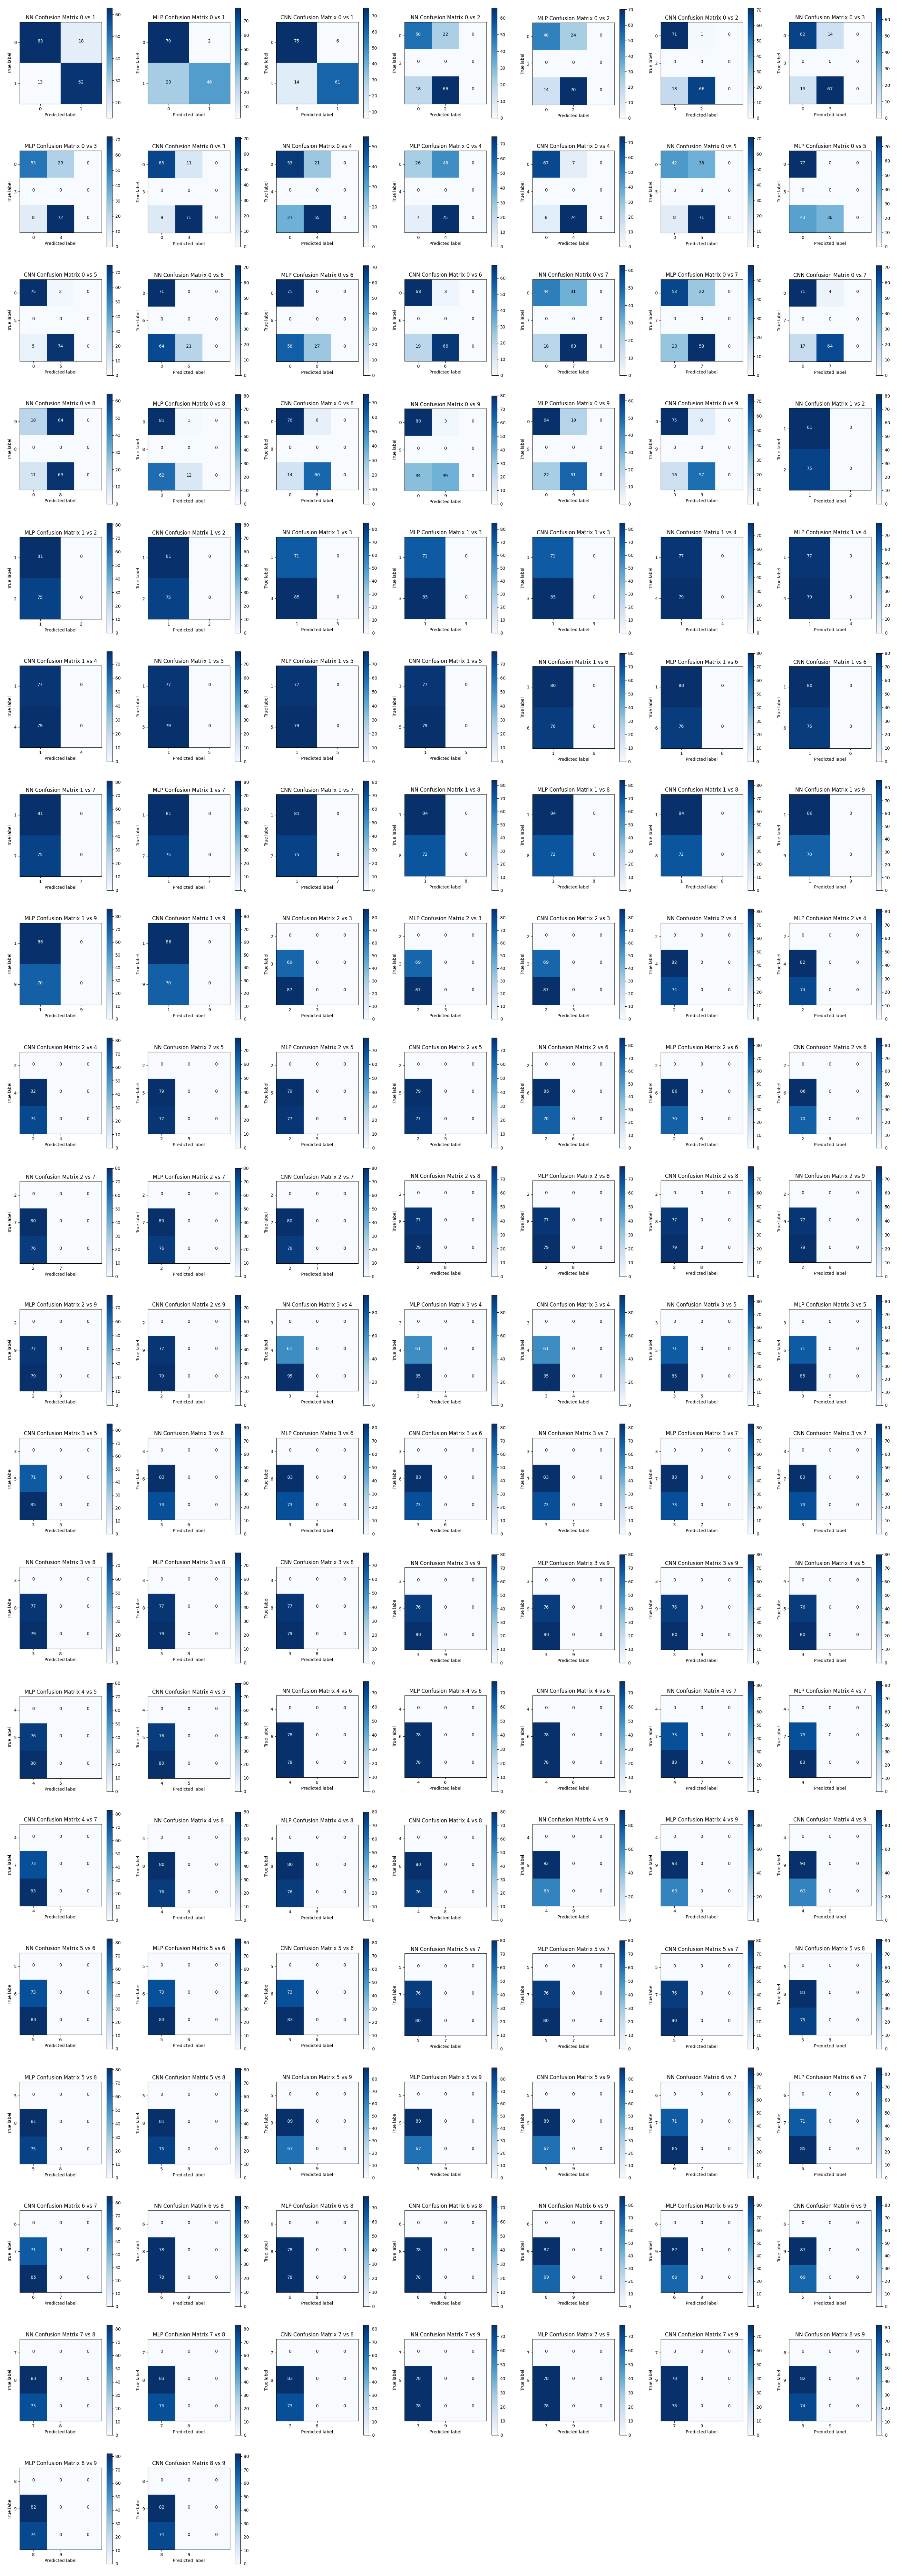

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# ฟังก์ชันในการบันทึก confusion matrix ภาพ
def save_confusion_matrix_image(cm, classes, title='Confusion matrix', save_path=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.close()  # Close the plot to prevent showing it interactively

# ฟังก์ชันในการสร้างตารางที่แสดง confusion matrix images
def create_confusion_matrix_table(image_paths, rows, cols, image_size=(4, 4)):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * image_size[0], rows * image_size[1]))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    for i, ax in enumerate(axes):
        if i < len(image_paths):
            img = plt.imread(image_paths[i])  # Read the image
            ax.imshow(img)
            ax.axis('off')  # Hide the axes

        else:
            ax.axis('off')  # Turn off unused subplots

    plt.tight_layout()
    plt.show()

# Now load and evaluate all saved models:

image_paths = []  # Store paths of saved confusion matrix images

for (class_a, class_b) in digit_pairs:
    print(f"\n--- Evaluating pair {class_a} vs {class_b} ---")
    classes_for_pair = [str(class_a), str(class_b)]
    
    # Load test loader again for this pair
    train_loader, test_loader = load_data('./thai-handwriting-number.appspot.com/thai-handwriting-number.appspot.com', classes_for_pair)
    
    for name, ModelClass in model_classes.items():
        print(f"Evaluating {name.upper()} on {class_a} vs {class_b}")
        
        model = ModelClass().to(device)
        checkpoint_path = f'checkpoints/{class_a}_vs_{class_b}_{name}.pth'
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        
        cm = evaluate_confusion_matrix(model, test_loader, device=device)
        
        # Define the path to save the image
        image_path = f'./confusion_matrices/{class_a}_vs_{class_b}_{name}.png'
        
        # Ensure the directory exists
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        
        # Save the confusion matrix image
        save_confusion_matrix_image(cm, classes=classes_for_pair, title=f'{name.upper()} Confusion Matrix {class_a} vs {class_b}', save_path=image_path)
        
        # Store the path of the saved image for later use
        image_paths.append(image_path)

# After processing all models, create a table with the confusion matrix images
num_images = len(image_paths)
cols = 7  # Number of columns per row
rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)  # Calculate the number of rows needed

# Create and display the table
create_confusion_matrix_table(image_paths, rows=rows, cols=cols)


Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.


Ans
1. ผลการทำงานของโมเดลต่างๆ จะต่างกันไปตามคู่ของตัวเลขในชุดข้อมูลบางคู่ โมเดลบางตัวอาจทำงานได้ดีในบางคู่ แต่ไม่ดีในคู่ที่แตกต่างกัน เนื่องจากโมเดลแต่ละตัวมีวิธีการมองและการเรียนรู้ที่ไม่เหมือนกัน บางโมเดลอาจจะเข้าใจรูปแบบของตัวเลขได้ดี แต่บางโมเดลอาจจะไม่เข้าใจเพราะมันอาจไม่ได้ฝึกมาให้รับรู้ตัวเลขในลักษณะนั้น
2. โมเดล Neural Network จะทำงานได้ดีในคู่ที่มีลักษณะเหมือนกัน เช่น ตัวเลขที่คล้ายกัน แต่มันอาจทำงานไม่ดีในคู่ที่มีความแตกต่างกันมาก เช่น ตัวเลขที่มีรูปร่างไม่เหมือนกันมาก โมเดล NN อาจจะไม่สามารถแยกแยะได้ดี เพราะในบางกรณีมันไม่ได้ฝึกมาให้มองความแตกต่างที่ละเอียด ในการดูแผนที่ฟีเจอร์ (feature maps) จะเห็นได้ว่าโมเดลอาจจะไม่สามารถจับข้อมูลที่สำคัญในบางชั้นได้
3. MLP และ CNN จะทำงานต่างกันกับ NN โดย CNN มักจะทำงานได้ดีกับข้อมูลที่มีลักษณะเป็นภาพเพราะมันสามารถจับลักษณะของรูปภาพได้ดีกว่า เช่น การแยกแยะรูปร่างของตัวเลข แต่ MLP จะทำงานได้ดีในกรณีที่ข้อมูลไม่ซับซ้อนและไม่มีรูปแบบที่เป็นมิติภาพมากนัก เหตุผลที่ CNN ทำงานได้ดีกว่า NN คือมันมีการใช้การเรียนรู้จากพื้นที่ต่าง ๆ ของภาพ ซึ่งช่วยให้มันจับลักษณะพิเศษได้ดีขึ้น
4. 
NN: ควรใช้เทคนิคการปรับแต่งพารามิเตอร์หรือเพิ่มข้อมูล (data augmentation) เพื่อช่วยให้โมเดลสามารถเรียนรู้ได้ดีขึ้นจากข้อมูลที่หลากหลาย

MLP: อาจต้องเพิ่มจำนวนชั้นหรือลองใช้ฟังก์ชันการกระตุ้น (activation function) ที่เหมาะสมเพื่อช่วยให้โมเดลเรียนรู้ความสัมพันธ์ที่ซับซ้อนได้ดีขึ้น

CNN: ควรเพิ่มขนาดของฟิลเตอร์หรือใช้เทคนิคการปรับแต่งที่ช่วยให้โมเดลสามารถจับลักษณะภาพได้ดียิ่งขึ้น โดยอาจเพิ่มจำนวนเลเยอร์เพื่อให้โมเดลมีความลึกในการเรียนรู้มากขึ้น